Created by Marina Dunn, Spring 2022

# Training Status

#### Training with year 10 data:

**Model 1b (complete):**

*Accuracy: 63% (Y10 train), 61% (Y10 test), 62% (Y10 validation), 62% (Y1 test)

*Precision (weighted): 67% (Y10 train), 65% (Y10 test), 65% (Y10 validation), 63% (Y1 test)

*Recall (weighted): 63% (Y10 train), 61% (Y10 test), 62% (Y10 validation), 62% (Y1 test)

*F1 (weighted): 64% (Y10 train), 61% (Y10 test), 62% (Y10 validation), 62% (Y1 test)

*higher loss: validation

**Model 3b (complete):**

*Accuracy: 57% (Y10 train), 55% (Y10 test), 57% (Y10 validation), 54% (Y1 test)

*Precision (weighted): 73% (Y10 train), 71% (Y10 test), 71% (Y10 validation), 56% (Y1 test)

*Recall (weighted): 57% (Y10 train), 55% (Y10 test), 57% (Y10 validation), 54% (Y1 test)

*F1 (weighted): 57% (Y10 train), 55% (Y10 test), 57% (Y10 validation), 54% (Y1 test)

*higher loss: validation

**ResNet18 Model (completed):**

*Accuracy: 93% (Y1 train), 81% (Y1 test), 82% (Y1 validation), 58% (Y10 test)

*Precision (weighted): 93% (Y1 train), 82% (Y1 test), 83% (Y1 validation), 63% (Y10 test)

*Recall (weighted): 93% (Y1 train), 81% (Y1 test), 82% (Y1 validation), 58% (Y10 test)

*F1 (weighted): 93% (Y1 train), 81% (Y1 test), 82% (Y1 validation), 57% (Y10 test)

*higher loss: Validation

**ResNet18 Model 2 (running):**

*Accuracy: % (Y1 train), % (Y1 test), % (Y1 validation), % (Y10 test)

*Precision (weighted): % (Y1 train), % (Y1 test), % (Y1 validation), % (Y10 test)

*Recall (weighted): % (Y1 train), % (Y1 test), % (Y1 validation), % (Y10 test)

*F1 (weighted): % (Y1 train), % (Y1 test), % (Y1 validation), % (Y10 test)

*higher loss: Validation


# Load Data & Import Packages

In [6]:
# Import user-defined functions
from ML_training_functions import generate_class_weights, mean_std, plot_filters

# system
import os
import datetime
import warnings
warnings.filterwarnings("ignore")

# arrays
import numpy as np
np.set_printoptions(edgeitems=25, linewidth=100000)
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 10000000

# building and training CNN
import tensorflow as tf
# main model building
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Model, model_from_json, load_model, save_model
# data augmentation
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# training
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
# transfer learning
from tensorflow.keras.layers import GlobalAveragePooling2D, Activation, ZeroPadding2D, AveragePooling2D, Add
# Load the TensorBoard notebook extension
%load_ext tensorboard

from sklearn.metrics import multilabel_confusion_matrix, plot_confusion_matrix 
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, log_loss
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, auc
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

## Plotting
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
# Graphics in retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [7]:
# Load year 1 train, test, validation image files (noisy)
X_train_1 = np.load('images_Y1_train.npy')
X_test_1 = np.load('images_Y1_test.npy')
X_valid_1 = np.load('images_Y1_valid.npy')

In [3]:

# Load year 10 train, test, validation image files (pristine)
X_train_10 = np.load('images_Y10_train.npy')
X_test_10 = np.load('images_Y10_test.npy')
X_valid_10 = np.load('images_Y10_valid.npy')

In [4]:

# Load small subset files
X_test_1_sub = np.load('images_Y1_test_150.npy')
X_test_10_sub = np.load('images_Y10_test_150.npy')
Y_test_sub = np.load('labels_test_150.npy')

In [5]:

# Load image label files
Y_train = np.load('labels_train.npy')
Y_test = np.load('labels_test.npy')
Y_valid = np.load('labels_valid.npy')

# Pre-process & Verify Data

In [8]:
# 3 Classes
class_names = ['Spiral', 'Elliptical', 'Merger']
NUM_CLASSES = len(class_names)

In [9]:
# check data sizes
NUM_TRAIN = 23487
NUM_TEST = 6715
NUM_VALIDATION = 3355
NUM_TOTAL = NUM_TRAIN + NUM_TEST + NUM_VALIDATION
print(NUM_TOTAL)
assert NUM_TOTAL == len(X_train_10) + len(X_test_10) + len(X_valid_10), "total\
training, test, validation samples not equal to total samples - exiting"

33557


In [10]:
print( "Data dimensions: ")
# same for years 10 and 1
print("Training Set:", np.shape(X_train_10)) 
print("Test Set:", np.shape(X_test_10))
print("Subset Test Set: ", np.shape(X_test_10_sub))
print("Validation Set:", np.shape(X_valid_10))

Data dimensions: 
Training Set: (23487, 3, 100, 100)
Test Set: (6715, 3, 100, 100)
Subset Test Set:  (150, 3, 100, 100)
Validation Set: (3355, 3, 100, 100)


In [11]:
# Dataset is imbalanced, so want to use class weights
class_weights = generate_class_weights(Y_train) # use for training

# See class weights for each set
print('Training class weights:', generate_class_weights(Y_train))
print('Test class weights:', generate_class_weights(Y_test))
print('Validation class weights:', generate_class_weights(Y_valid))

Training class weights: {0: 0.7815713287411401, 1: 1.372304995617879, 2: 1.0082421120412106}
Test class weights: {0: 0.7818139480731168, 1: 1.3723686899652565, 2: 1.0078042923607984}
Validation class weights: {0: 0.7809590316573557, 1: 1.3721881390593047, 2: 1.0093261131167268}


### Plot histograms of pixel values for each filter before scaling

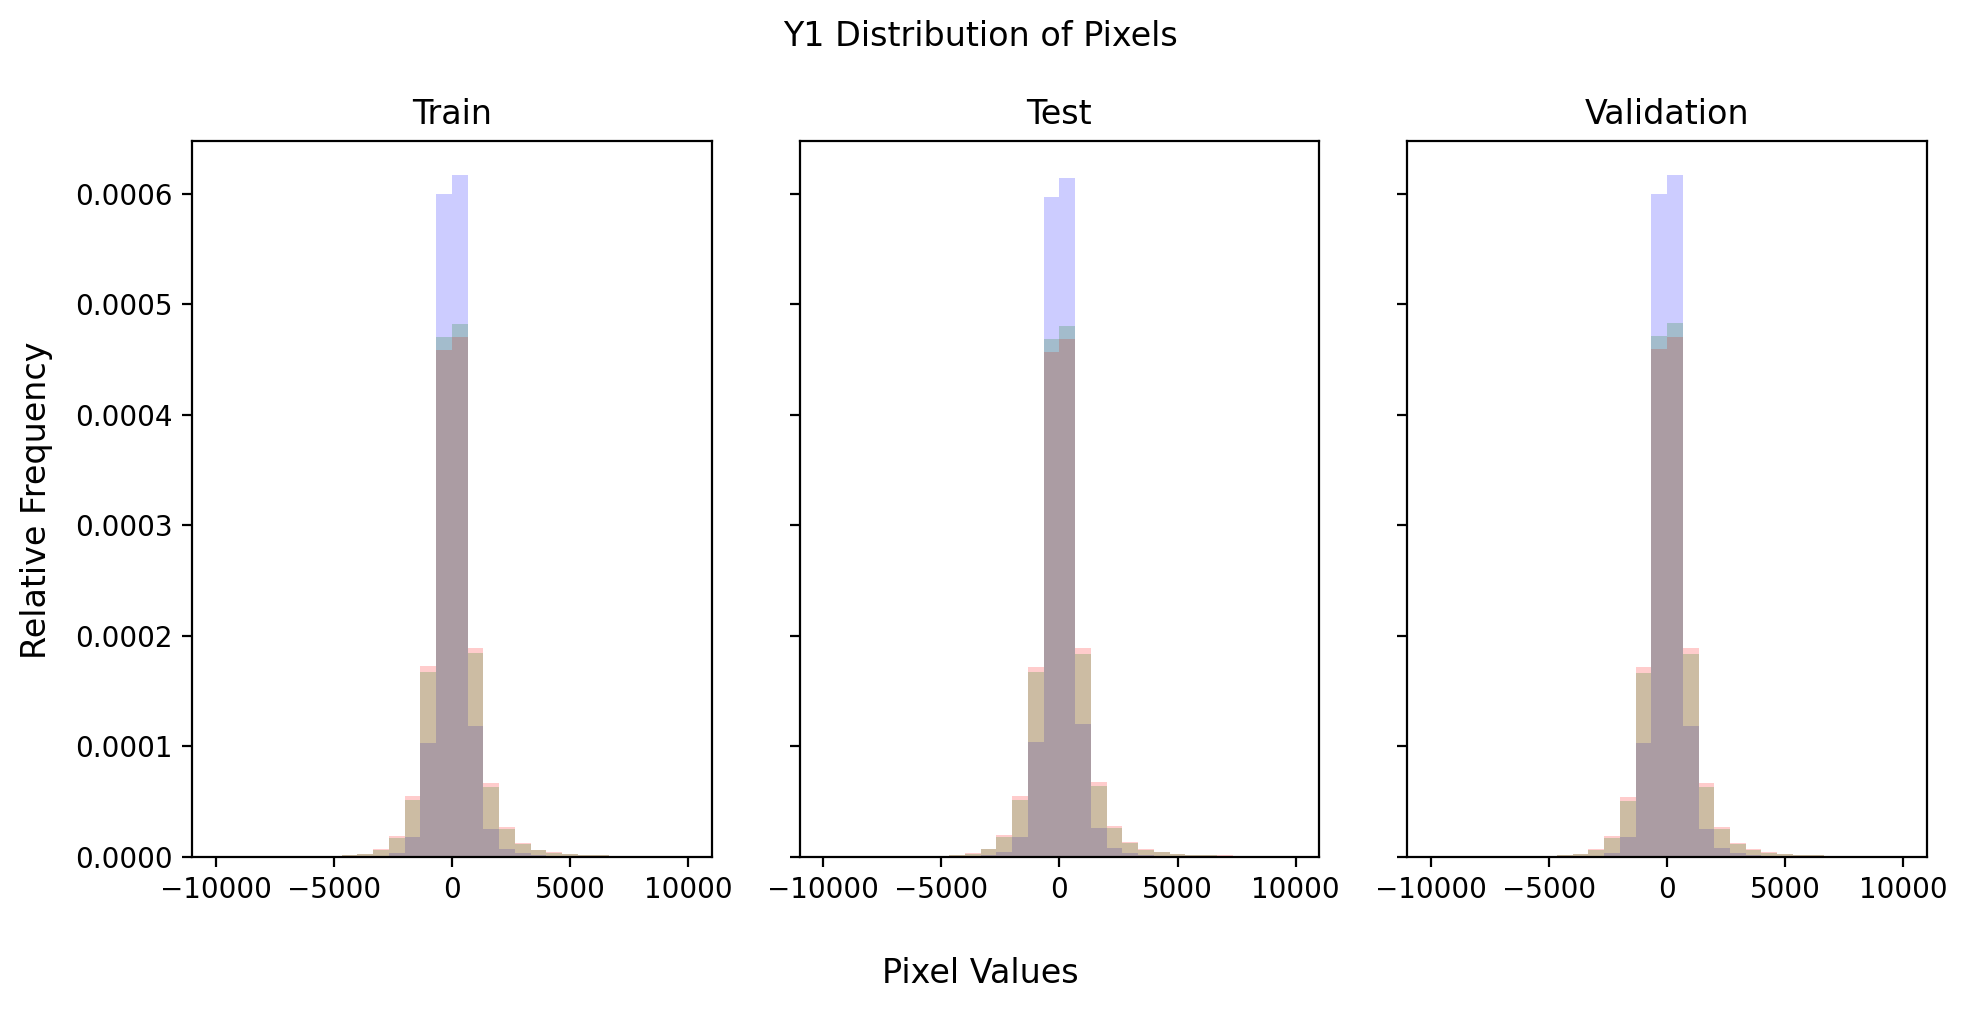

Train:

Min: -13510.646, Max: 1178185.250
Min: -24637.709, Max: 2572829.750
Min: -21624.816, Max: 2082440.500

Test:

Min: -13510.646, Max: 1178185.250
Min: -21407.996, Max: 2572829.750
Min: -18490.619, Max: 2082440.500

Validation:

Min: -8950.646, Max: 456532.875
Min: -17342.955, Max: 952291.688
Min: -18021.842, Max: 765298.688


In [12]:
# Year 1
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)

ax1.hist(X_train_1[:, 0].ravel(), bins=30, color = 'blue', alpha = 0.2, density=True, range=[-10000, 10000], stacked=True)
ax1.hist(X_train_1[:, 1].ravel(), bins=30, color = 'red', alpha = 0.2, density=True, range=[-10000, 10000], stacked=True)
ax1.hist(X_train_1[:, 2].ravel(), bins=30, color = 'green', alpha = 0.2, density=True, range=[-10000, 10000], stacked=True)
ax1.set_title("Train")

ax2.hist(X_test_1[:, 0].ravel(), bins=30, color = 'blue', alpha = 0.2, density=True, range=[-10000, 10000], stacked=True)
ax2.hist(X_test_1[:, 1].ravel(), bins=30, color = 'red', alpha = 0.2, density=True, range=[-10000, 10000], stacked=True)
ax2.hist(X_test_1[:, 2].ravel(), bins=30, color = 'green', alpha = 0.2, density=True, range=[-10000, 10000], stacked=True)
ax2.set_title("Test")

ax3.hist(X_valid_1[:, 0].ravel(), bins=30, color = 'blue', alpha = 0.2, density=True, range=[-10000, 10000], stacked=True)
ax3.hist(X_valid_1[:, 1].ravel(), bins=30, color = 'red', alpha = 0.2, density=True, range=[-10000, 10000], stacked=True)
ax3.hist(X_valid_1[:, 2].ravel(), bins=30, color = 'green', alpha = 0.2, density=True, range=[-10000, 10000], stacked=True)
ax3.set_title("Validation")

fig.suptitle("Y1 Distribution of Pixels")
fig.supxlabel("Pixel Values")
fig.supylabel("Relative Frequency")
plt.tight_layout()
#plt.savefig("Y1_pixels.jpg")
plt.show()

print('Train:\n')
print('Min: %.3f, Max: %.3f' % (np.amin(X_train_1[:, 0]), np.amax(X_train_1[:, 0])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_train_1[:, 1]), np.amax(X_train_1[:, 1])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_train_1[:, 2]), np.amax(X_train_1[:, 2])))

print('\nTest:\n')
print('Min: %.3f, Max: %.3f' % (np.amin(X_test_1[:, 0]), np.amax(X_test_1[:, 0])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_test_1[:, 1]), np.amax(X_test_1[:, 1])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_test_1[:, 2]), np.amax(X_test_1[:, 2])))

print('\nValidation:\n')
print('Min: %.3f, Max: %.3f' % (np.amin(X_valid_1[:, 0]), np.amax(X_valid_1[:, 0])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_valid_1[:, 1]), np.amax(X_valid_1[:, 1])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_valid_1[:, 2]), np.amax(X_valid_1[:, 2])))

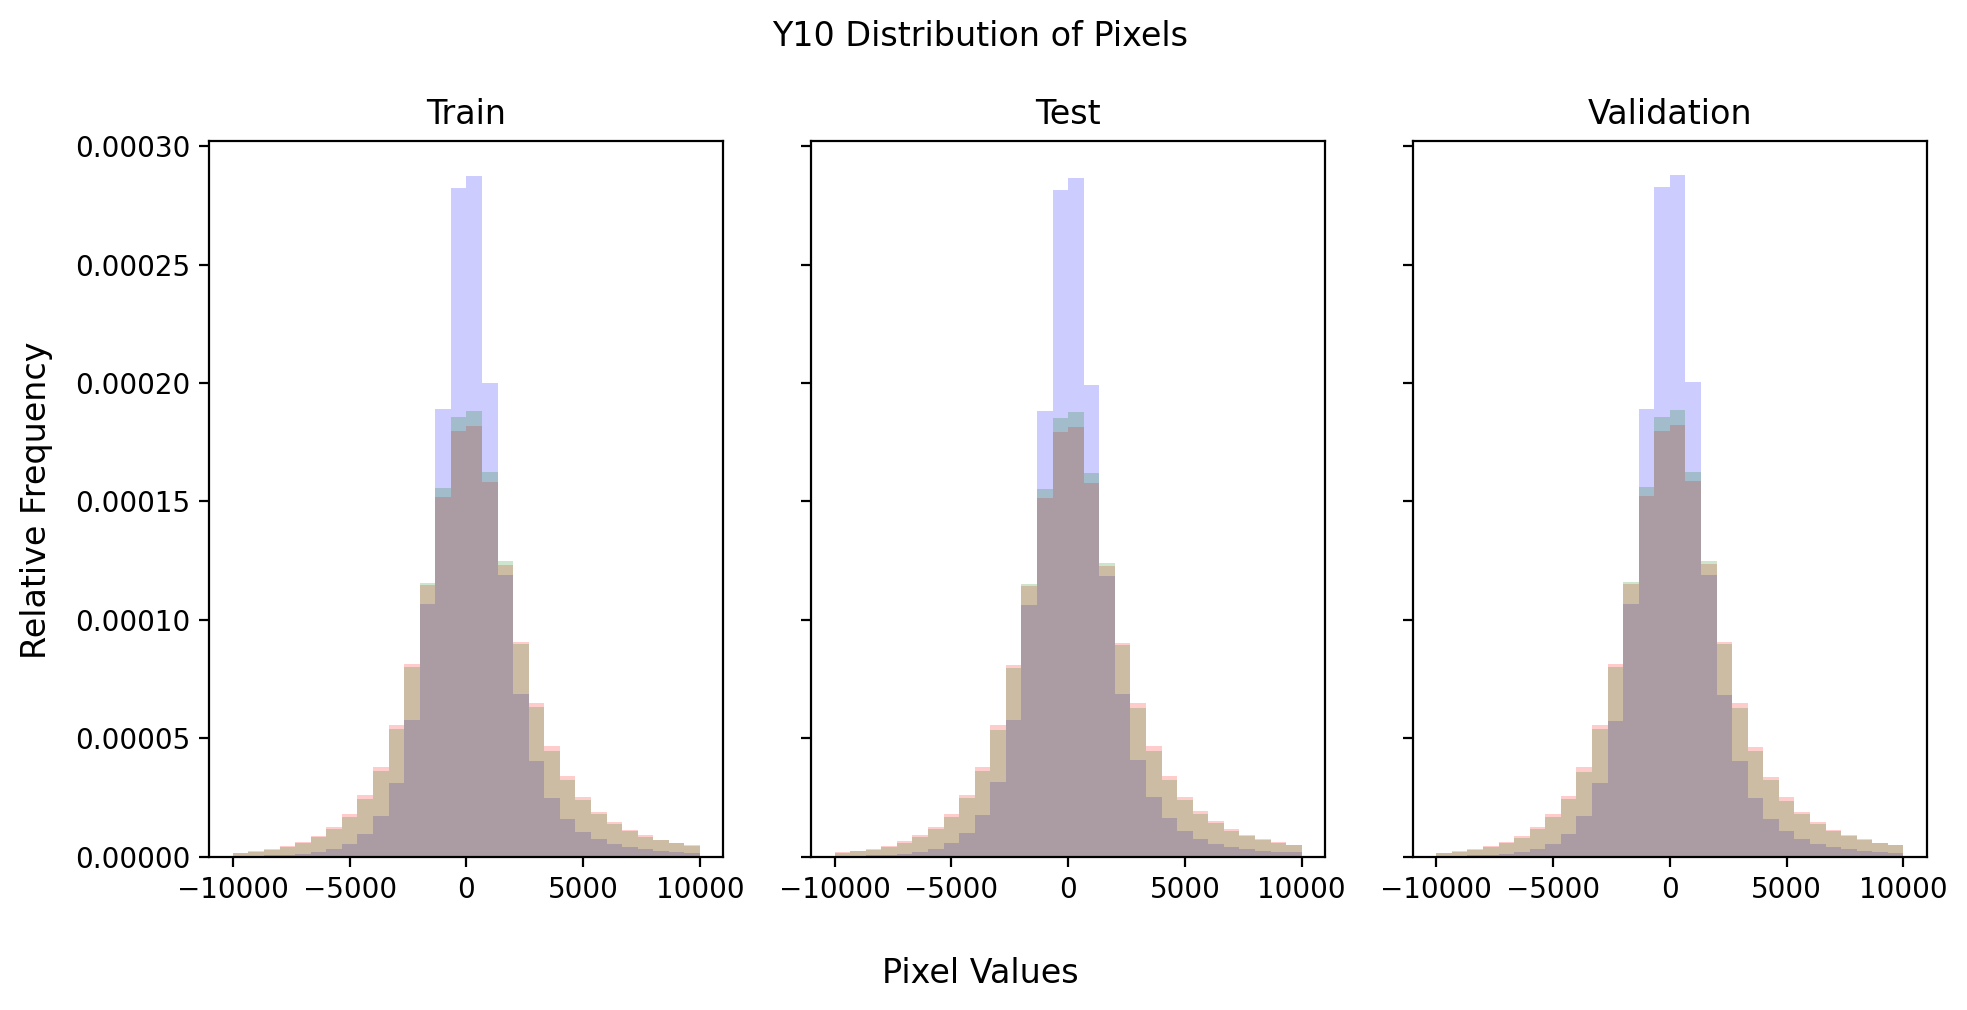

Train:

Min: -45121.941, Max: 11785052.000
Min: -61172.262, Max: 25809146.000
Min: -71376.992, Max: 20926832.000

Test:

Min: -39141.316, Max: 11785052.000
Min: -50422.684, Max: 25809146.000
Min: -57522.105, Max: 20926832.000

Validation:

Min: -24953.631, Max: 4572029.500
Min: -48626.875, Max: 9514766.000
Min: -53579.691, Max: 7667693.500


In [13]:
# Year 10
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)

ax1.hist(X_train_10[:, 0].ravel(), bins=30, color = 'blue', alpha = 0.2, density=True, range=[-10000, 10000], stacked=True)
ax1.hist(X_train_10[:, 1].ravel(), bins=30, color = 'red', alpha = 0.2, density=True, range=[-10000, 10000], stacked=True)
ax1.hist(X_train_10[:, 2].ravel(), bins=30, color = 'green', alpha = 0.2, density=True, range=[-10000, 10000], stacked=True)
ax1.set_title("Train")

ax2.hist(X_test_10[:, 0].ravel(), bins=30, color = 'blue', alpha = 0.2, density=True, range=[-10000, 10000], stacked=True)
ax2.hist(X_test_10[:, 1].ravel(), bins=30, color = 'red', alpha = 0.2, density=True, range=[-10000, 10000], stacked=True)
ax2.hist(X_test_10[:, 2].ravel(), bins=30, color = 'green', alpha = 0.2, density=True, range=[-10000, 10000], stacked=True)
ax2.set_title("Test")

ax3.hist(X_valid_10[:, 0].ravel(), bins=30, color = 'blue', alpha = 0.2, density=True, range=[-10000, 10000], stacked=True)
ax3.hist(X_valid_10[:, 1].ravel(), bins=30, color = 'red', alpha = 0.2, density=True, range=[-10000, 10000], stacked=True)
ax3.hist(X_valid_10[:, 2].ravel(), bins=30, color = 'green', alpha = 0.2, density=True, range=[-10000, 10000], stacked=True)
ax3.set_title("Validation")

fig.suptitle("Y10 Distribution of Pixels")
fig.supxlabel("Pixel Values")
fig.supylabel("Relative Frequency")
plt.tight_layout()
#plt.savefig("Y10_pixels.jpg")
plt.show()

print('Train:\n')
print('Min: %.3f, Max: %.3f' % (np.amin(X_train_10[:, 0]), np.amax(X_train_10[:, 0])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_train_10[:, 1]), np.amax(X_train_10[:, 1])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_train_10[:, 2]), np.amax(X_train_10[:, 2])))

print('\nTest:\n')
print('Min: %.3f, Max: %.3f' % (np.amin(X_test_10[:, 0]), np.amax(X_test_10[:, 0])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_test_10[:, 1]), np.amax(X_test_10[:, 1])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_test_10[:, 2]), np.amax(X_test_10[:, 2])))

print('\nValidation:\n')
print('Min: %.3f, Max: %.3f' % (np.amin(X_valid_10[:, 0]), np.amax(X_valid_10[:, 0])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_valid_10[:, 1]), np.amax(X_valid_10[:, 1])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_valid_10[:, 2]), np.amax(X_valid_10[:, 2])))

### Normalize Pixel Values

In [14]:
from numpy import arcsinh as arcsinh

def scale_pixels(t):
    #first clip outliers based on global values
    global_min = np.percentile(t, 0.1)
    global_max = np.percentile(t, 99.9)
    #global_max = np.percentile(t, 100)
    print(global_max)

    for i in range(0, 3):
        #g, r, i
        c = .85/global_max #gets you close to arcsinh(max_x) = 1, arcsinh(min_x) = 0
        t[:,i] = np.clip(t[:,i], global_min, global_max)
        t[:,i] = arcsinh(c*t[:, i])
        t[:,i] = (t[:,i] + 1.0) / 2.0
        
scale_pixels(X_train_1)
scale_pixels(X_test_1)
scale_pixels(X_valid_1)

scale_pixels(X_train_10)
scale_pixels(X_test_10)
scale_pixels(X_valid_10)

19341.90625
19725.8673691437
18785.857636722387
191915.796875
195783.140625
186349.641984398


### Plot histograms of pixel values for each filter after scaling

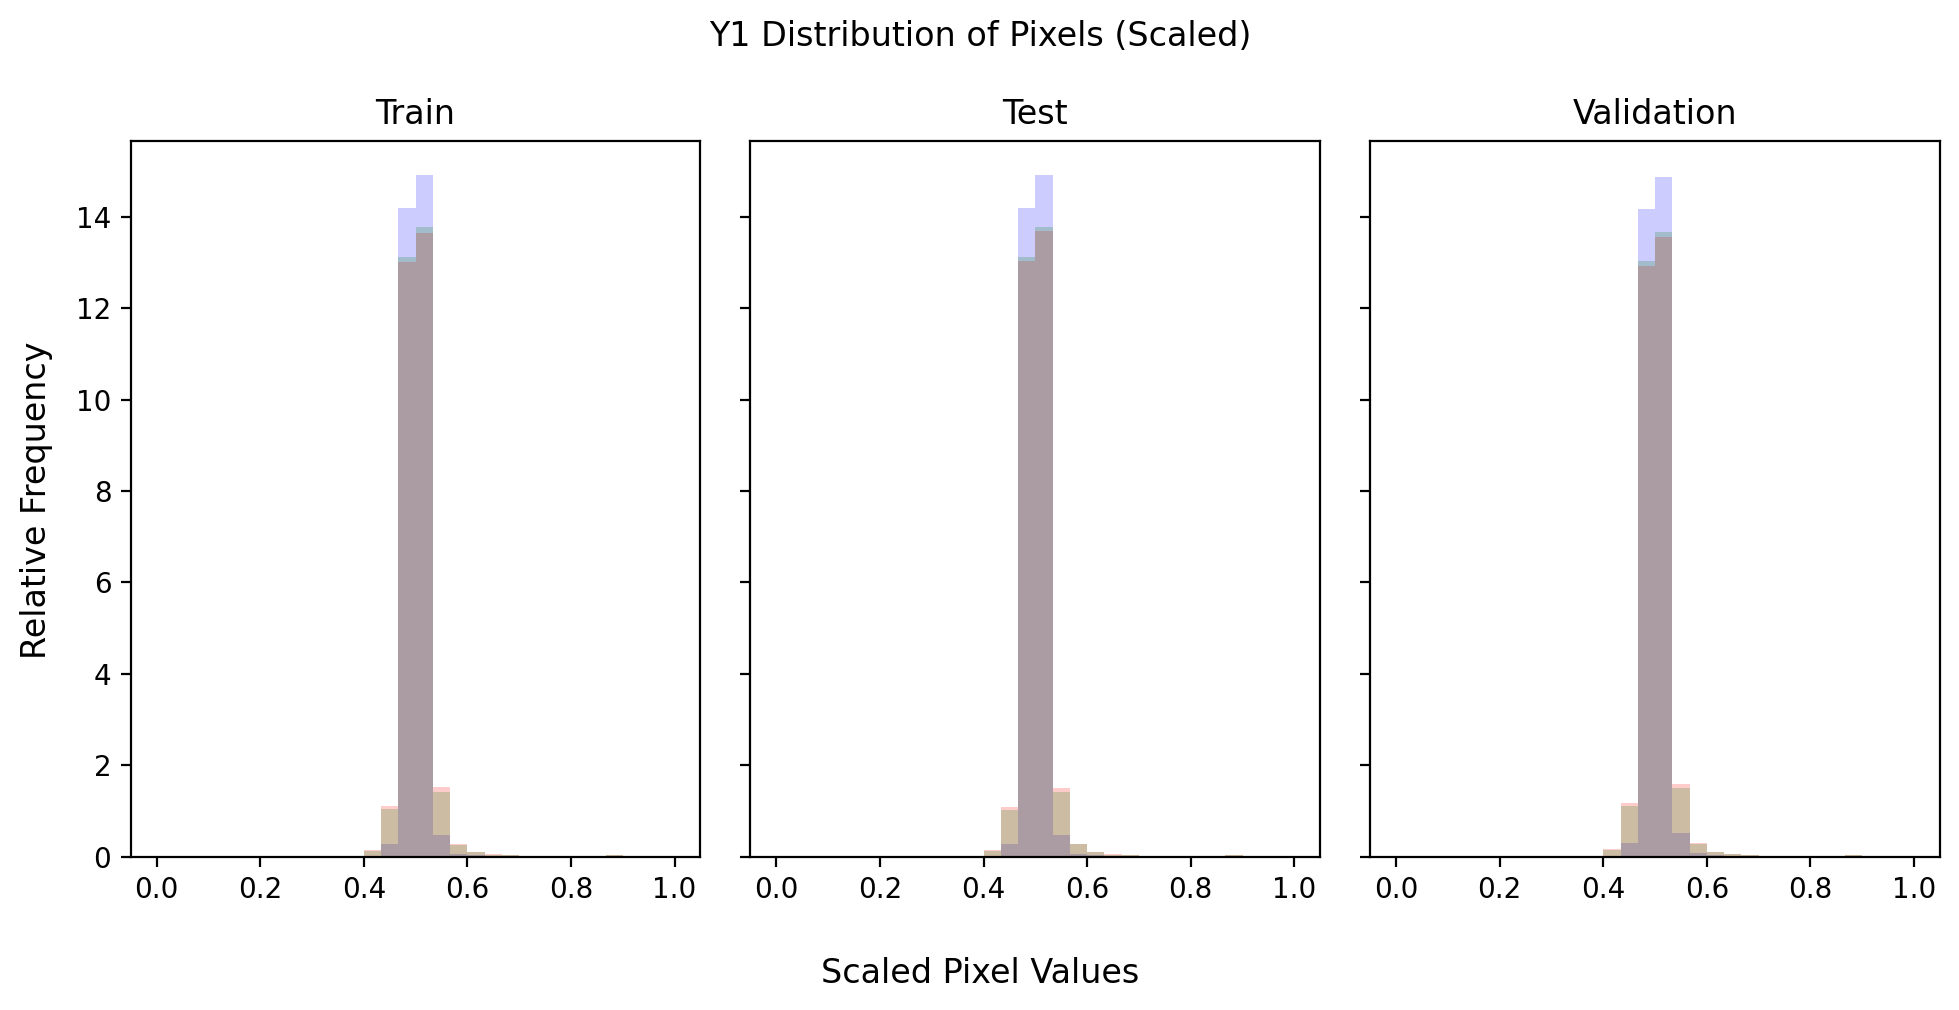

Train:

Min: 0.412, Max: 0.886
Min: 0.412, Max: 0.886
Min: 0.412, Max: 0.886

Test:

Min: 0.412, Max: 0.886
Min: 0.412, Max: 0.886
Min: 0.412, Max: 0.886

Validation:

Min: 0.410, Max: 0.886
Min: 0.410, Max: 0.886
Min: 0.410, Max: 0.886


In [15]:
# year 1
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)

ax1.hist(X_train_1[:, 0].ravel(), bins=30, color = 'blue', alpha = 0.2, density=True, range=[0, 1], stacked=True)
ax1.hist(X_train_1[:, 1].ravel(), bins=30, color = 'red', alpha = 0.2, density=True, range=[0, 1], stacked=True)
ax1.hist(X_train_1[:, 2].ravel(), bins=30, color = 'green', alpha = 0.2, density=True, range=[0, 1], stacked=True)
ax1.set_title("Train")

ax2.hist(X_test_1[:, 0].ravel(), bins=30, color = 'blue', alpha = 0.2, density=True, range=[0, 1], stacked=True)
ax2.hist(X_test_1[:, 1].ravel(), bins=30, color = 'red', alpha = 0.2, density=True, range=[0, 1], stacked=True)
ax2.hist(X_test_1[:, 2].ravel(), bins=30, color = 'green', alpha = 0.2, density=True, range=[0, 1], stacked=True)
ax2.set_title("Test")

ax3.hist(X_valid_1[:, 0].ravel(), bins=30, color = 'blue', alpha = 0.2, density=True, range=[0, 1], stacked=True)
ax3.hist(X_valid_1[:, 1].ravel(), bins=30, color = 'red', alpha = 0.2, density=True, range=[0, 1], stacked=True)
ax3.hist(X_valid_1[:, 2].ravel(), bins=30, color = 'green', alpha = 0.2, density=True, range=[0, 1], stacked=True)
ax3.set_title("Validation")

fig.suptitle("Y1 Distribution of Pixels (Scaled)")
fig.supxlabel("Scaled Pixel Values")
fig.supylabel("Relative Frequency")
plt.tight_layout()
#plt.savefig("Y1_pixels_scaled.jpg")
plt.show()

print('Train:\n')
print('Min: %.3f, Max: %.3f' % (np.amin(X_train_1[:, 0]), np.amax(X_train_1[:, 0])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_train_1[:, 1]), np.amax(X_train_1[:, 1])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_train_1[:, 2]), np.amax(X_train_1[:, 2])))

print('\nTest:\n')
print('Min: %.3f, Max: %.3f' % (np.amin(X_test_1[:, 0]), np.amax(X_test_1[:, 0])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_test_1[:, 1]), np.amax(X_test_1[:, 1])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_test_1[:, 2]), np.amax(X_test_1[:, 2])))

print('\nValidation:\n')
print('Min: %.3f, Max: %.3f' % (np.amin(X_valid_1[:, 0]), np.amax(X_valid_1[:, 0])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_valid_1[:, 1]), np.amax(X_valid_1[:, 1])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_valid_1[:, 2]), np.amax(X_valid_1[:, 2])))

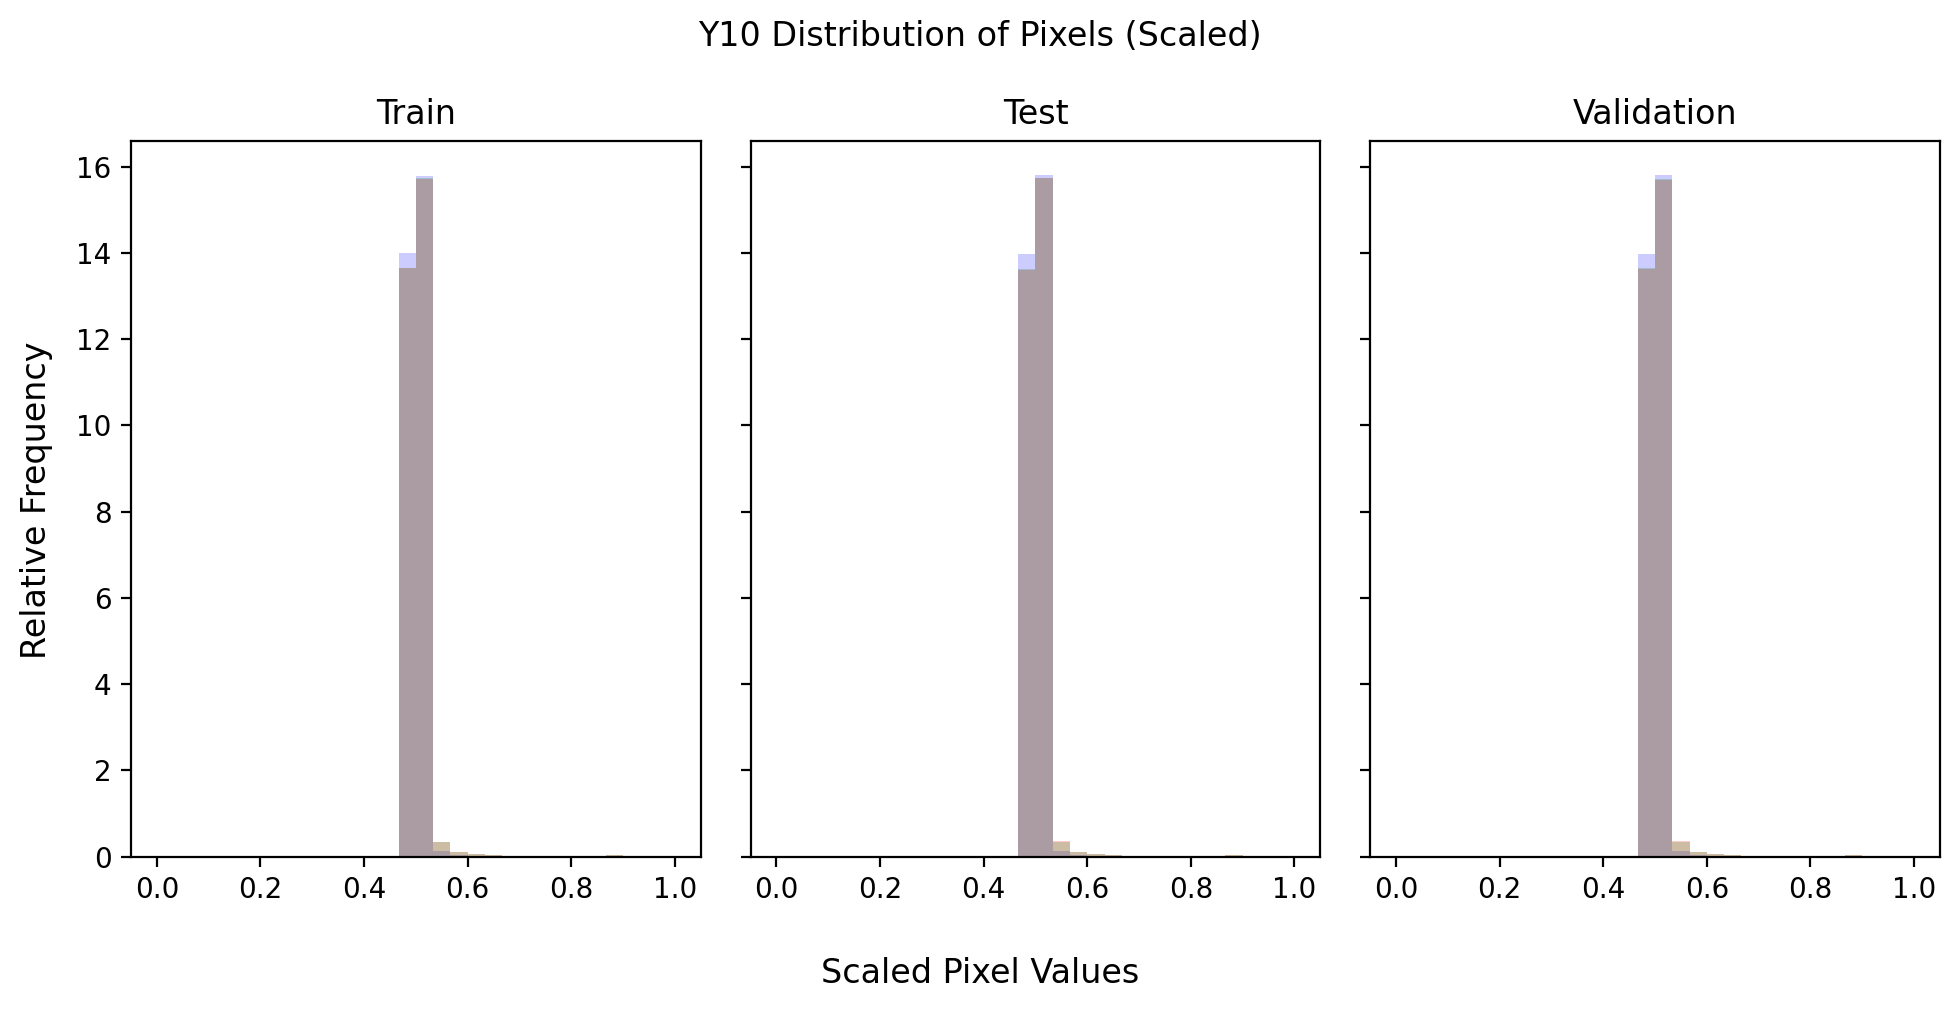

Train:

Min: 0.474, Max: 0.886
Min: 0.474, Max: 0.886
Min: 0.474, Max: 0.886

Test:

Min: 0.474, Max: 0.886
Min: 0.474, Max: 0.886
Min: 0.474, Max: 0.886

Validation:

Min: 0.473, Max: 0.886
Min: 0.473, Max: 0.886
Min: 0.473, Max: 0.886


In [16]:
# year 10
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)

ax1.hist(X_train_10[:, 0].ravel(), bins=30, color = 'blue', alpha = 0.2, density=True, range=[0, 1], stacked=True)
ax1.hist(X_train_10[:, 1].ravel(), bins=30, color = 'red', alpha = 0.2, density=True, range=[0, 1], stacked=True)
ax1.hist(X_train_10[:, 2].ravel(), bins=30, color = 'green', alpha = 0.2, density=True, range=[0, 1], stacked=True)
ax1.set_title("Train")

ax2.hist(X_test_10[:, 0].ravel(), bins=30, color = 'blue', alpha = 0.2, density=True, range=[0, 1], stacked=True)
ax2.hist(X_test_10[:, 1].ravel(), bins=30, color = 'red', alpha = 0.2, density=True, range=[0, 1], stacked=True)
ax2.hist(X_test_10[:, 2].ravel(), bins=30, color = 'green', alpha = 0.2, density=True, range=[0, 1], stacked=True)
ax2.set_title("Test")

ax3.hist(X_valid_10[:, 0].ravel(), bins=30, color = 'blue', alpha = 0.2, density=True, range=[0, 1], stacked=True)
ax3.hist(X_valid_10[:, 1].ravel(), bins=30, color = 'red', alpha = 0.2, density=True, range=[0, 1], stacked=True)
ax3.hist(X_valid_10[:, 2].ravel(), bins=30, color = 'green', alpha = 0.2, density=True, range=[0, 1], stacked=True)
ax3.set_title("Validation")

fig.suptitle("Y10 Distribution of Pixels (Scaled)")
fig.supxlabel("Scaled Pixel Values")
fig.supylabel("Relative Frequency")
plt.tight_layout()
#plt.savefig("Y10_pixels_scaled.jpg")
plt.show()

print('Train:\n')
print('Min: %.3f, Max: %.3f' % (np.amin(X_train_10[:, 0]), np.amax(X_train_10[:, 0])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_train_10[:, 1]), np.amax(X_train_10[:, 1])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_train_10[:, 2]), np.amax(X_train_10[:, 2])))

print('\nTest:\n')
print('Min: %.3f, Max: %.3f' % (np.amin(X_test_10[:, 0]), np.amax(X_test_10[:, 0])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_test_10[:, 1]), np.amax(X_test_10[:, 1])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_test_10[:, 2]), np.amax(X_test_10[:, 2])))

print('\nValidation:\n')
print('Min: %.3f, Max: %.3f' % (np.amin(X_valid_10[:, 0]), np.amax(X_valid_10[:, 0])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_valid_10[:, 1]), np.amax(X_valid_10[:, 1])))
print('Min: %.3f, Max: %.3f' % (np.amin(X_valid_10[:, 2]), np.amax(X_valid_10[:, 2])))

### Example Images

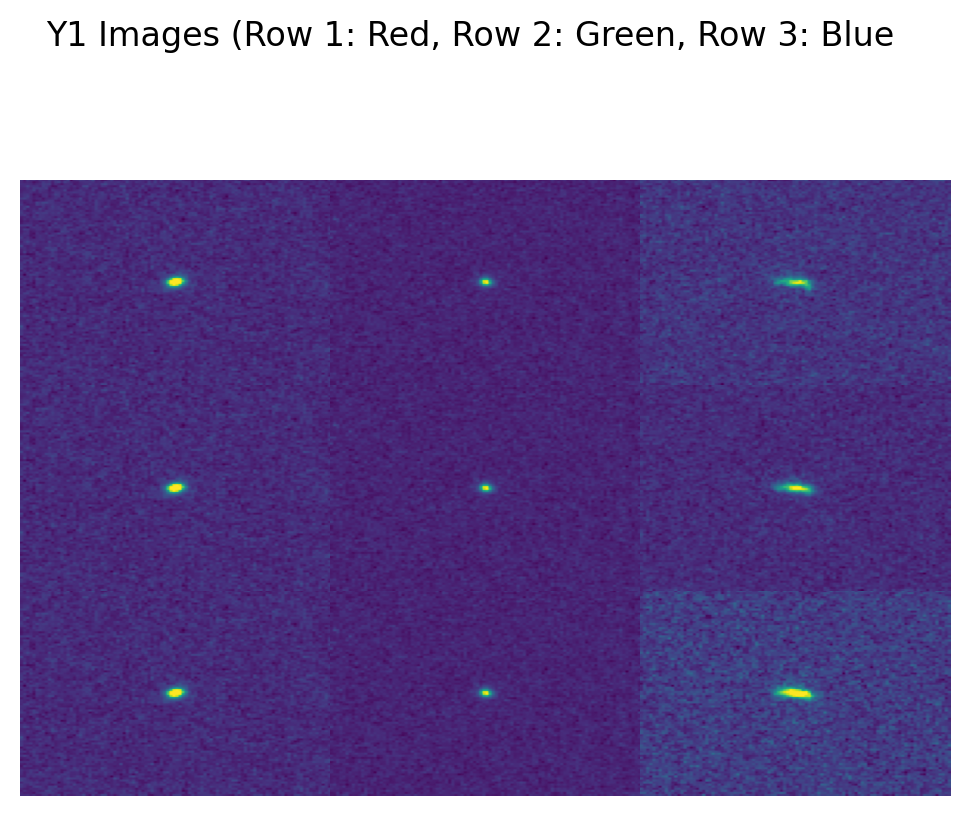

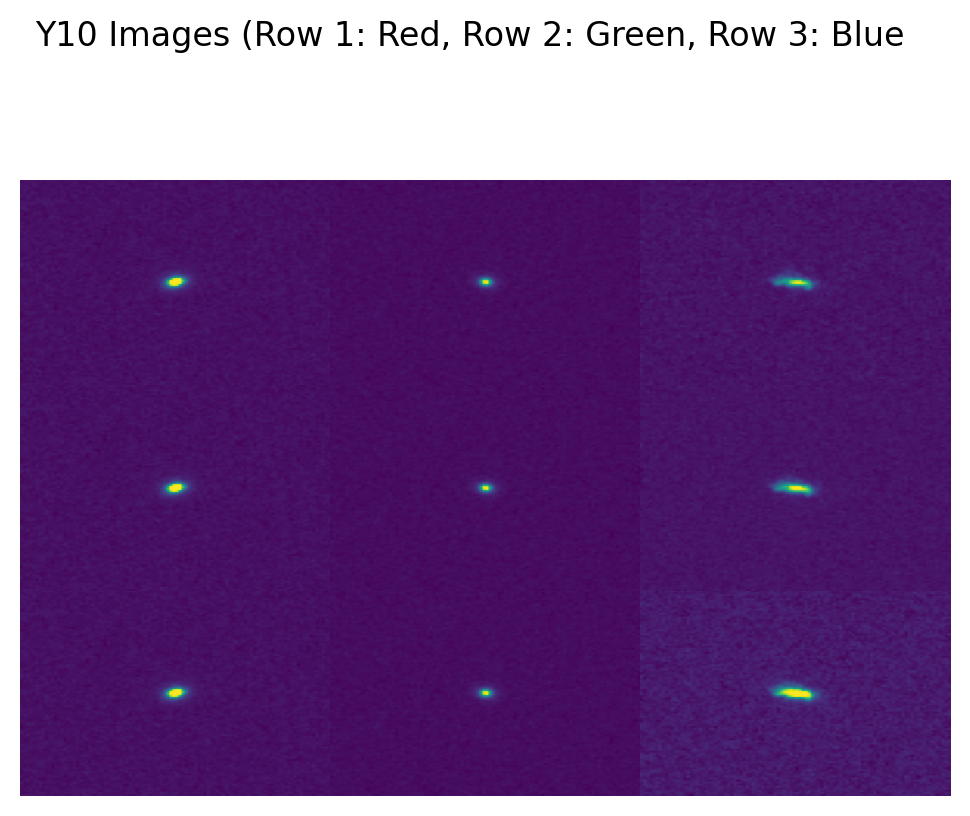

In [8]:
# Example images
examples_1 = [X_train_1[42,1], X_train_1[254,1], X_train_1[623,0],
            X_train_1[42,1], X_train_1[254,1], X_train_1[623,1],
            X_train_1[42,1], X_train_1[254,1], X_train_1[623,2]
            ]

examples_2 = [X_train_10[42,1], X_train_10[254,1], X_train_10[623,0],
            X_train_10[42,1], X_train_10[254,1], X_train_10[623,1],
            X_train_10[42,1], X_train_10[254,1], X_train_10[623,2]
            ]

fig1 = plt.figure(figsize=(6,8))
for i, image in enumerate(examples_1):
    fig1.suptitle('Y1 Images (Row 1: Red, Row 2: Green, Row 3: Blue', fontsize=12)
    plt.subplot(6, 3, i + 1)
    plt.axis("off")
    plt.imshow(image, aspect='auto', cmap='viridis')
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig(fname=f"Y1 RGB Example Images", format='jpg')
plt.show()

fig2 = plt.figure(figsize=(6,8))
for i, image in enumerate(examples_2):
    fig2.suptitle('Y10 Images (Row 1: Red, Row 2: Green, Row 3: Blue', fontsize=12)
    plt.subplot(6, 3, i + 1)
    plt.axis("off")
    plt.imshow(image, aspect='auto', cmap='viridis')
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig(fname=f"Y10 RGB Example Images", format='jpg')
plt.show()

# Exploratory Data Analysis

In [9]:
# Labels are one-hot encoded
Y_train_df = pd.DataFrame(Y_train)
Y_test_df = pd.DataFrame(Y_test)
Y_valid_df = pd.DataFrame(Y_valid)

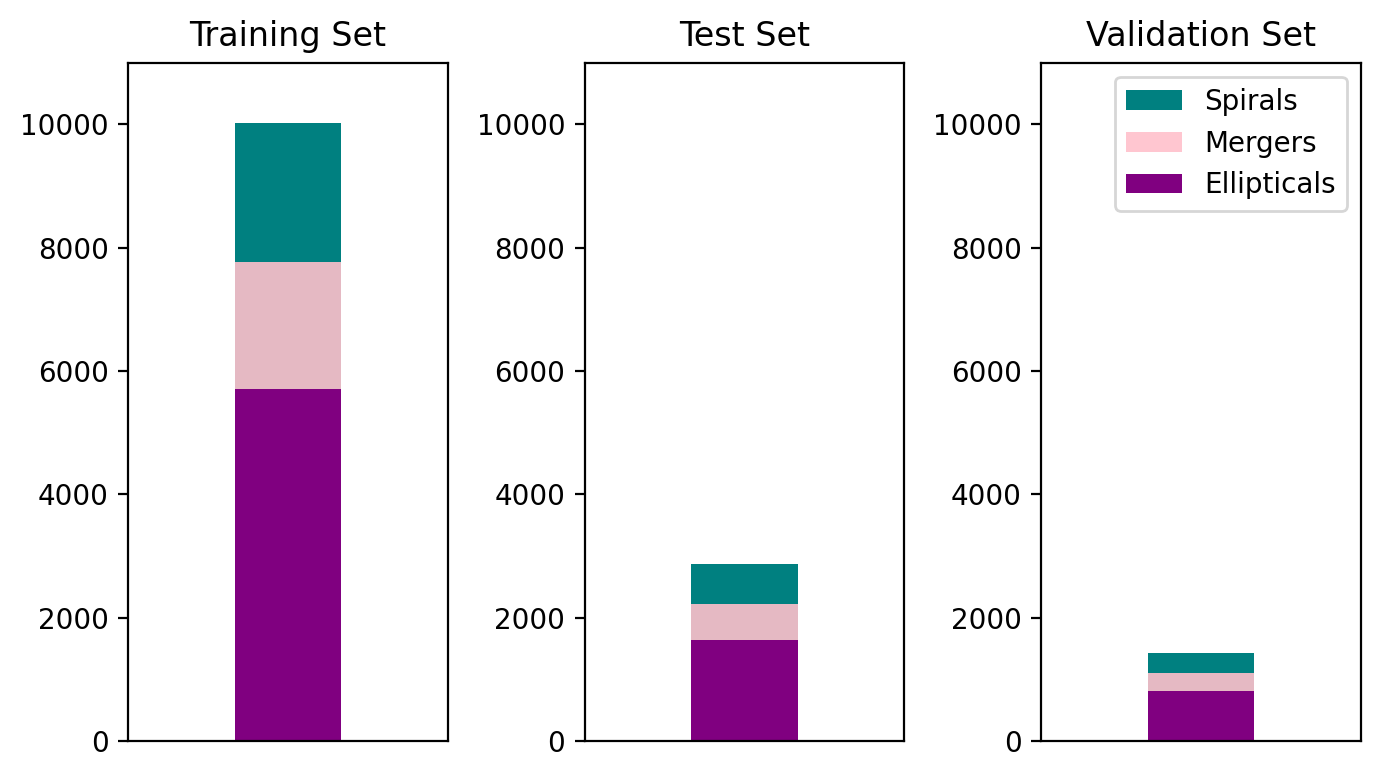

In [10]:
# Datasets by label
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7, 4))

ax1.hist(Y_train_df[0].loc[Y_train_df[0] == 1.], label='Spirals', histtype='bar', color='teal')
ax1.hist(Y_train_df[2].loc[Y_train_df[2] == 1.], label='Mergers', histtype='bar', color='pink', alpha = 0.9)
ax1.hist(Y_train_df[1].loc[Y_train_df[1] == 1.], label='Ellipticals', histtype='bar', color='purple')
ax1.get_xaxis().set_visible(False)
ax1.set_xlim(0.9,1.2)
ax1.set_ylim(0,11000)
ax1.set_title('Training Set')

ax2.hist(Y_test_df[0].loc[Y_test_df[0] == 1.], label='Spirals', histtype='bar', color='teal')
ax2.hist(Y_test_df[2].loc[Y_test_df[2] == 1.], label='Mergers', histtype='bar', color='pink', alpha = 0.9)  
ax2.hist(Y_test_df[1].loc[Y_test_df[1] == 1.],label='Ellipticals', histtype='bar', color='purple')
ax2.get_xaxis().set_visible(False)
ax2.set_xlim(0.9,1.2)
ax2.set_ylim(0,11000)
ax2.set_title('Test Set')

ax3.hist(Y_valid_df[0].loc[Y_valid_df[0] == 1.], label='Spirals', histtype='bar', color='teal')
ax3.hist(Y_valid_df[2].loc[Y_valid_df[2] == 1.], label='Mergers', histtype='bar', color='pink', alpha = 0.9)
ax3.hist(Y_valid_df[1].loc[Y_valid_df[1] == 1.],label='Ellipticals', histtype='bar',color='purple')
ax3.get_xaxis().set_visible(False)
ax3.set_xlim(0.9,1.2)
ax3.set_ylim(0,11000)
ax3.set_title('Validation Set')

plt.tight_layout()
plt.legend()
plt.savefig(fname=f"Dataset by label", format='jpg')
plt.show()

# Create Deterministic CNN Model

### Model 1b

Similar to DeepMerge architecture

Loss: Categorical Cross-entropy

Optimizer: Adam (default learning rate too large- try 1e-4)

Uses Image Augmentation: False

In [13]:
## Define model architecture with the Functional API
# channels first: (channels, rows, cols)
input_shape = (3, 100, 100)

# Input layer (visible layer)
x = Input(shape=input_shape)

# Hidden layers
c0 = Conv2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_1')(x)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_1')(b0)
e0 = Dropout(0.1)(d0)

c1 = Conv2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_2')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_2')(b1)
e1 = Dropout(0.1)(d1)

c2 = Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_3')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format='channels_first', name='maxpool_3')(b2)
e2 = Dropout(0.1)(d2)

# Flatten the 3D output to 1D
f = Flatten()(e2)
z0 = Dense(64, activation='relu', kernel_regularizer=l2(0.0001), name='dense_1')(f)
z1 = Dense(32, activation='relu', kernel_regularizer=l2(0.0001), name='dense_2')(z0)
# Output layer: creates 3 one-hot encoded output values, one for each class
y = Dense(NUM_CLASSES, activation='softmax', name='output')(z1)

model = tf.keras.Model(inputs=x, outputs=y, name="Model-1b")

## Compile Model
loss = CategoricalCrossentropy(from_logits=True)
optimizer = Adam(learning_rate=1e-4)
compile_model(model, loss=loss, optimizer = optimizer)

Model: "Model-1b"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 3, 100, 100)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 8, 100, 100)       608       
                                                                 
 batch_normalization_6 (Batc  (None, 8, 100, 100)      400       
 hNormalization)                                                 
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 8, 50, 50)         0         
                                                                 
 dropout_6 (Dropout)         (None, 8, 50, 50)         0         
                                                                 
 conv_2 (Conv2D)             (None, 16, 50, 50)        1168      
                                                          

In [14]:
## Define Callback Functions
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10),
      ModelCheckpoint(filepath='Y10_best_weights.h5', monitor='val_accuracy',
                      mode='max', verbose=0, save_best_only=True)
      ]

In [15]:
## Train Model
batch_size = 128
NUM_EPOCH = 200

history = model.fit(X_train_10, Y_train,
                    batch_size = batch_size,
                    epochs = NUM_EPOCH,
                    validation_data = (X_valid_10, Y_valid),                
                    shuffle = True,
                    class_weight = class_weights,
                    verbose = 1,
                    callbacks = es
            )

Epoch 1/200


2022-10-18 12:47:22.551534: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-18 12:47:23.257021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


184/184 [==============================] - ETA: 0s - loss: 1.1236 - accuracy: 0.3780

2022-10-18 12:48:30.785503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


184/184 [==============================] - 69s 373ms/step - loss: 1.1236 - accuracy: 0.3780 - val_loss: 1.0841 - val_accuracy: 0.4411
Epoch 2/200
184/184 [==============================] - 66s 361ms/step - loss: 1.0731 - accuracy: 0.4578 - val_loss: 1.0600 - val_accuracy: 0.4650
Epoch 3/200
184/184 [==============================] - 67s 364ms/step - loss: 1.0541 - accuracy: 0.4966 - val_loss: 1.0458 - val_accuracy: 0.4882
Epoch 4/200
184/184 [==============================] - 67s 364ms/step - loss: 1.0395 - accuracy: 0.5068 - val_loss: 1.0357 - val_accuracy: 0.4814
Epoch 5/200
184/184 [==============================] - 67s 365ms/step - loss: 1.0207 - accuracy: 0.5138 - val_loss: 1.0209 - val_accuracy: 0.4799
Epoch 6/200
184/184 [==============================] - 74s 400ms/step - loss: 0.9898 - accuracy: 0.5416 - val_loss: 1.0006 - val_accuracy: 0.4909
Epoch 7/200
184/184 [==============================] - 67s 364ms/step - loss: 0.9650 - accuracy: 0.5483 - val_loss: 1.0096 - val_accurac

INFO:tensorflow:Assets written to: Model-1b.json/assets


INFO:tensorflow:Assets written to: Model-1b.json/assets


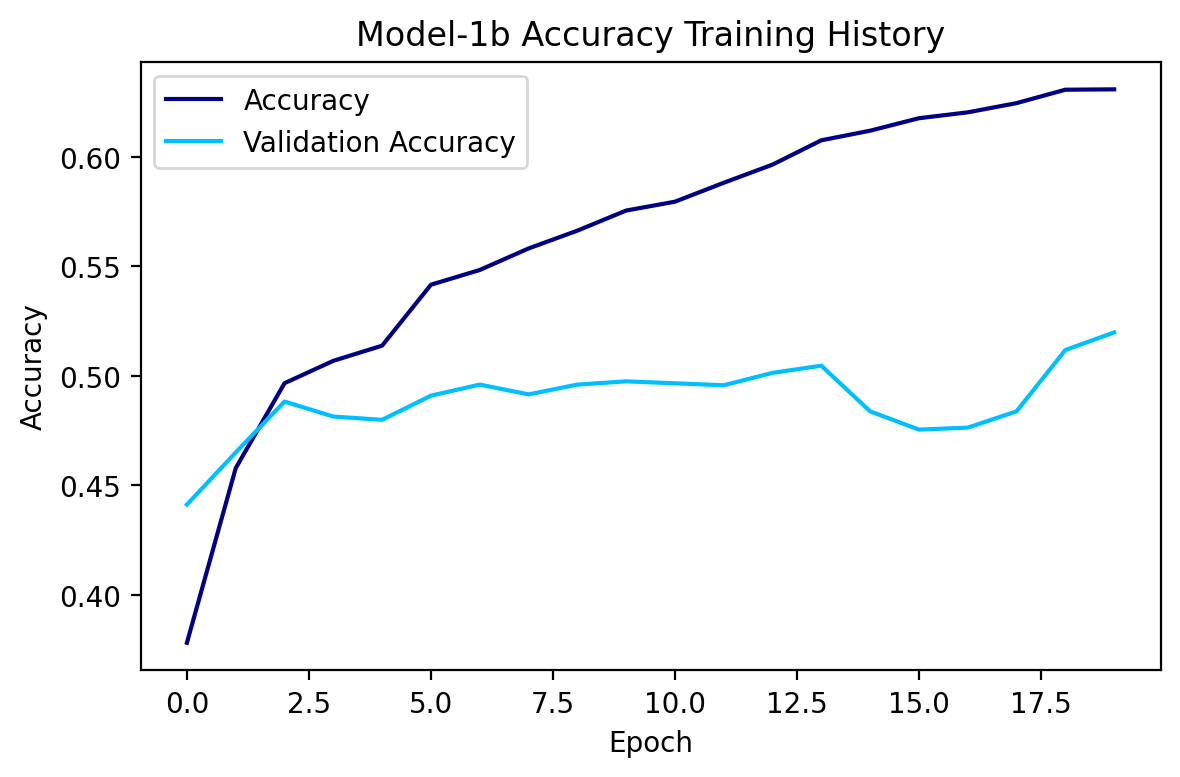

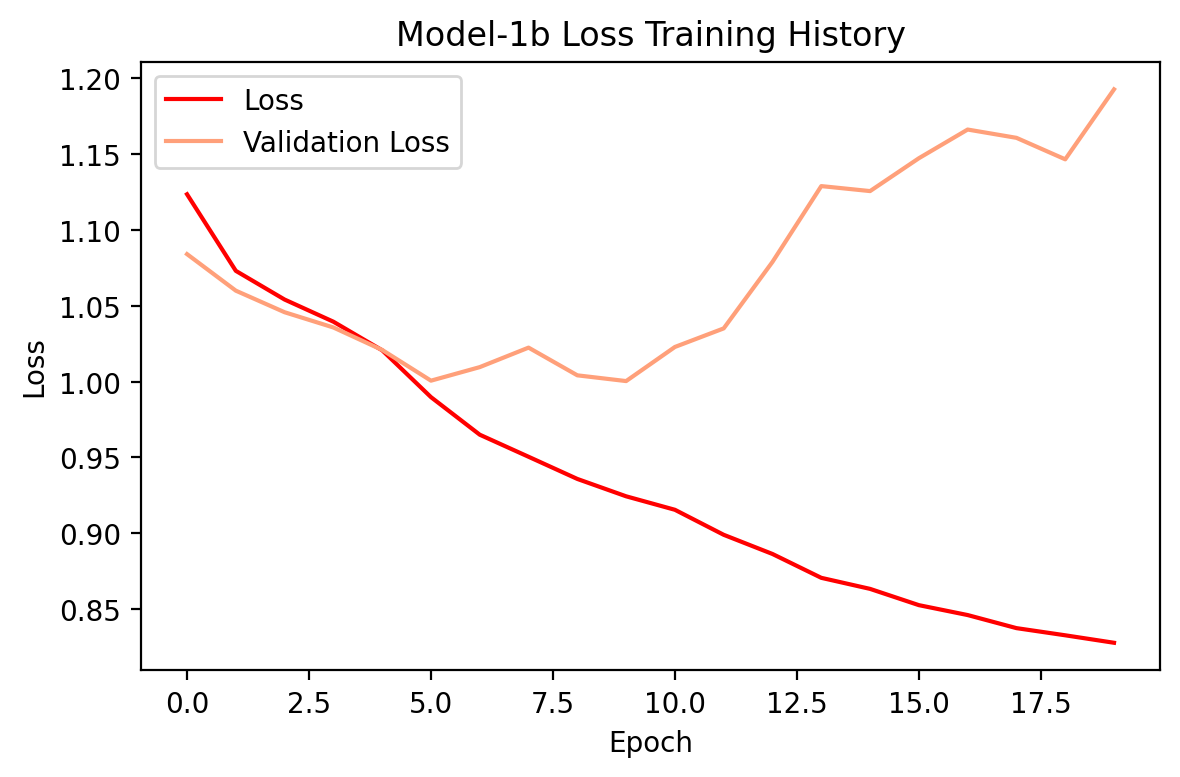

In [16]:
# Save model data
save_model_data(model, history)

# Plot training history
plot_training(model, history)

In [17]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model.predict(X_train_10)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_train, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Train:\n" + classification_metrics + '\n')

# Confusion Matrix
cd = make_cm(model, 
              np.argmax(Y_train, axis=1), 
              np.argmax(model.predict(X_train_10), axis=1)
              )
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'{model.name} Train Confusion Matrix')
plt.tight_layout()
plt.savefig(fname=f'{model.name}_train_CM', format='png')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_train[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title(f'{model.name}Train ROC Curves')
plt.savefig(fname=f'{model.name}_train_ROC', format='png')
plt.show()

  2/734 [..............................] - ETA: 47s 

2022-10-18 13:10:59.399853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


734/734 [==============================] - 7s 10ms/step


NameError: name 'class_names' is not defined

210/210 [==============================] - 2s 11ms/step
Test:
              precision    recall  f1-score   support

      Spiral       0.80      0.65      0.72      2863
  Elliptical       0.45      0.77      0.57      1631
      Merger       0.61      0.44      0.51      2221

    accuracy                           0.61      6715
   macro avg       0.62      0.62      0.60      6715
weighted avg       0.65      0.61      0.61      6715


210/210 [==============================] - 2s 11ms/step


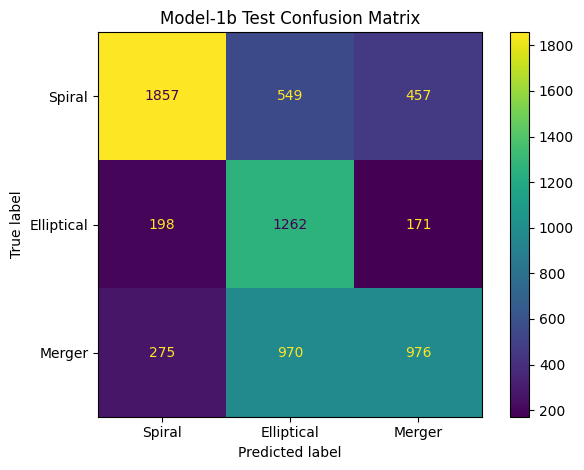

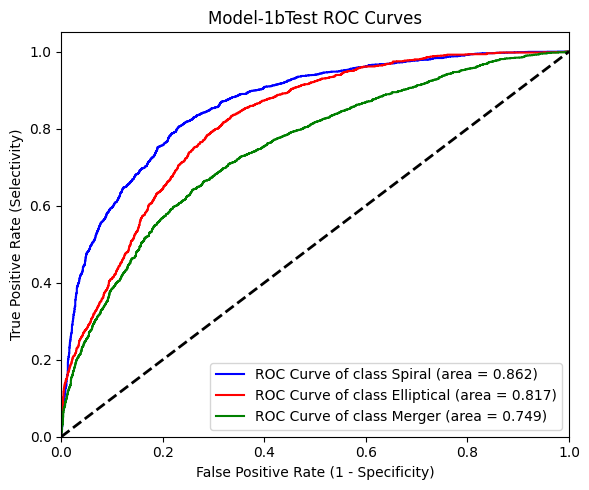

In [ ]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model.predict(X_test_10)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_test, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Test:\n" + classification_metrics + '\n')

# Confusion Matrix
cd = make_cm(model, 
              np.argmax(Y_test, axis=1), 
              np.argmax(model.predict(X_test_10), axis=1)
              )
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'{model.name} Test Confusion Matrix')
plt.tight_layout()
plt.savefig(fname=f'{model.name}_test_CM', format='png')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title(f'{model.name}Test ROC Curves')
plt.savefig(fname=f'{model.name}_test_ROC', format='png')
plt.show()

105/105 [==============================] - 1s 11ms/step
Validation:
              precision    recall  f1-score   support

      Spiral       0.80      0.66      0.72      1432
  Elliptical       0.48      0.78      0.59       815
      Merger       0.59      0.45      0.51      1108

    accuracy                           0.62      3355
   macro avg       0.62      0.63      0.61      3355
weighted avg       0.65      0.62      0.62      3355


105/105 [==============================] - 1s 11ms/step


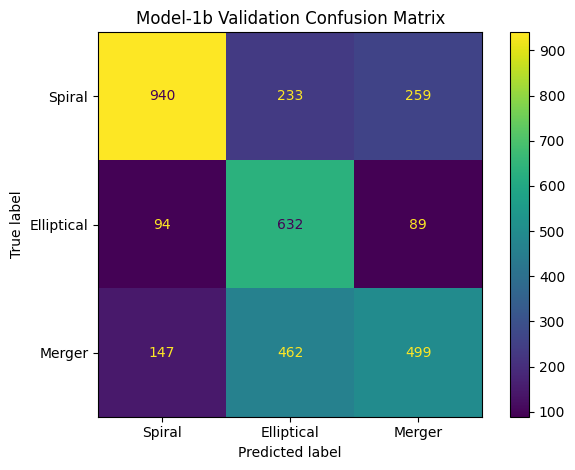

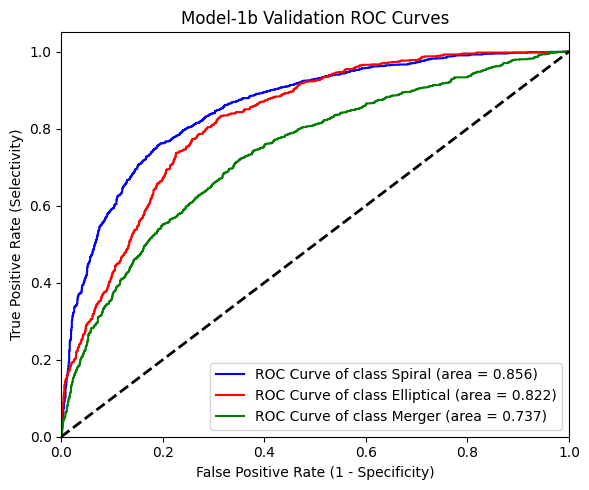

In [ ]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model.predict(X_valid_10)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_valid, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Validation:\n" + classification_metrics + '\n')

# Confusion Matrix
cd = make_cm(model, 
              np.argmax(Y_valid, axis=1), 
              np.argmax(model.predict(X_valid_10), axis=1)
              )
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'{model.name} Validation Confusion Matrix')
plt.tight_layout()
plt.savefig(fname=f'{model.name}_validation_CM', format='png')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_valid[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title(f'{model.name} Validation ROC Curves')
plt.tight_layout()
plt.savefig(fname=f'{model.name}_validation_ROC', format='png')
plt.show()

In [ ]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model.predict(X_test_1)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_test, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Year 1 Test:\n" + classification_metrics + '\n')

210/210 [==============================] - 2s 11ms/step
Year 1 Test:
              precision    recall  f1-score   support

      Spiral       0.74      0.69      0.72      2863
  Elliptical       0.51      0.40      0.45      1631
      Merger       0.55      0.69      0.62      2221

    accuracy                           0.62      6715
   macro avg       0.60      0.60      0.59      6715
weighted avg       0.63      0.62      0.62      6715




### Model 3b
Similar to DeepMerge architecture but added pooling padding

Loss: Categorical Cross-entropy

Optimizer: Adam

Uses Image Augmentation: False

Change: Back to Model 1 architecture; try padding in pooling

In [52]:
## Define model architecture with the Functional API
input_shape = (3, 100, 100)
x = Input(shape=input_shape)

c0 = Conv2D(8, kernel_size=(5, 5), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_1')(x)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', data_format='channels_first', name='maxpool_1')(b0)
e0 = Dropout(0.1)(d0)

c1 = Conv2D(16, kernel_size=(3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_2')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', data_format='channels_first', name='maxpool_2')(b1)
e1 = Dropout(0.1)(d1)

c2 = Conv2D(32, kernel_size=(3, 3), activation='relu', strides=(1, 1), padding='same', data_format='channels_first', name='conv_3')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=2, padding='same', data_format='channels_first', name='maxpool_3')(b2)
e2 = Dropout(0.1)(d2)

f = Flatten()(e2)
z0 = Dense(64, activation='relu', kernel_regularizer=l2(0.0001), name='dense_1')(f)
z1 = Dense(32, activation='relu', kernel_regularizer=l2(0.0001), name='dense_2')(z0)
y = Dense(NUM_CLASSES, activation='softmax', name='output')(z1)

model_3 = Model(inputs=x, outputs=y, name="Model-3b")

## Compile Model
loss = CategoricalCrossentropy(from_logits=True)
optimizer = Adam()
compile_model(model_3, loss=loss, optimizer = optimizer)

Model: "Model-3b"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 3, 100, 100)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 8, 100, 100)       608       
                                                                 
 batch_normalization_12 (Bat  (None, 8, 100, 100)      400       
 chNormalization)                                                
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 8, 50, 50)         0         
                                                                 
 dropout_12 (Dropout)        (None, 8, 50, 50)         0         
                                                                 
 conv_2 (Conv2D)             (None, 16, 50, 50)        1168      
                                                          

In [53]:
## Define Callback Functions
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10),
        ModelCheckpoint(filepath='Y10_best_weights.h5', monitor='val_accuracy', 
                        mode='max', verbose=1, save_best_only=True)
      ]

In [54]:
## Train model
batch_size = 128
NUM_EPOCH = 200

history_3 = model_3.fit(X_train_10, Y_train,
                    batch_size = batch_size,
                    epochs = NUM_EPOCH,
                    validation_data = (X_valid_10, Y_valid),
                    shuffle = True,
                    class_weight = class_weights,
                    verbose = 1,
                    callbacks = es
            )

Epoch 1/200


2022-10-06 12:33:09.613626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


184/184 [==============================] - ETA: 0s - loss: 1.1605 - accuracy: 0.3669

2022-10-06 12:34:20.067856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.42683, saving model to Y10_best_weights.h5
184/184 [==============================] - 72s 386ms/step - loss: 1.1605 - accuracy: 0.3669 - val_loss: 1.2535 - val_accuracy: 0.4268
Epoch 2/200
184/184 [==============================] - ETA: 0s - loss: 1.0683 - accuracy: 0.4673
Epoch 2: val_accuracy did not improve from 0.42683
184/184 [==============================] - 67s 365ms/step - loss: 1.0683 - accuracy: 0.4673 - val_loss: 2.2769 - val_accuracy: 0.2429
Epoch 3/200
184/184 [==============================] - ETA: 0s - loss: 1.0316 - accuracy: 0.5184
Epoch 3: val_accuracy did not improve from 0.42683
184/184 [==============================] - 67s 366ms/step - loss: 1.0316 - accuracy: 0.5184 - val_loss: 3.5800 - val_accuracy: 0.2429
Epoch 4/200
184/184 [==============================] - ETA: 0s - loss: 0.9987 - accuracy: 0.5385
Epoch 4: val_accuracy did not improve from 0.42683
184/184 [==============================] - 68s 369ms/step - loss

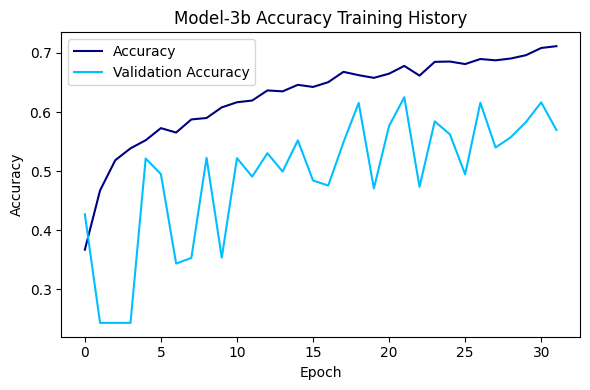

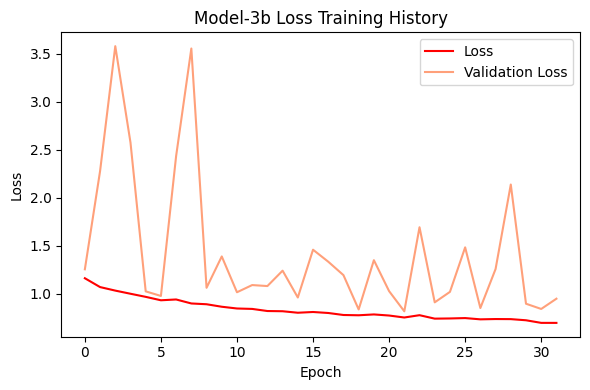

In [57]:
## Save model data
save_model_data(model_3, history_3)

# Plot training history
plot_training(model_3, history_3)

2022-10-06 13:20:21.216150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


734/734 [==============================] - 11s 12ms/step
Train:
              precision    recall  f1-score   support

      Spiral       0.90      0.57      0.70     10017
  Elliptical       0.38      0.95      0.55      5705
      Merger       0.78      0.30      0.43      7765

    accuracy                           0.57     23487
   macro avg       0.69      0.61      0.56     23487
weighted avg       0.73      0.57      0.57     23487


734/734 [==============================] - 9s 11ms/step


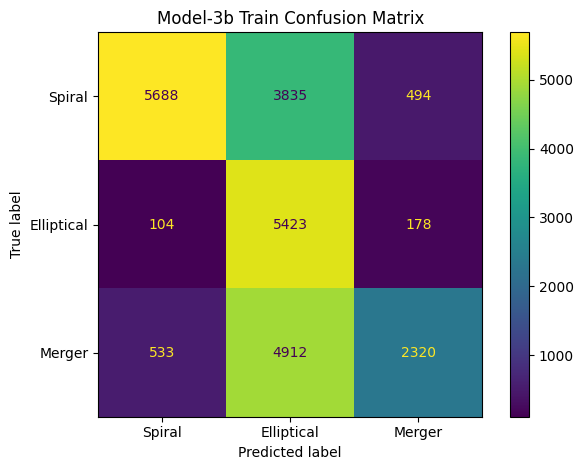

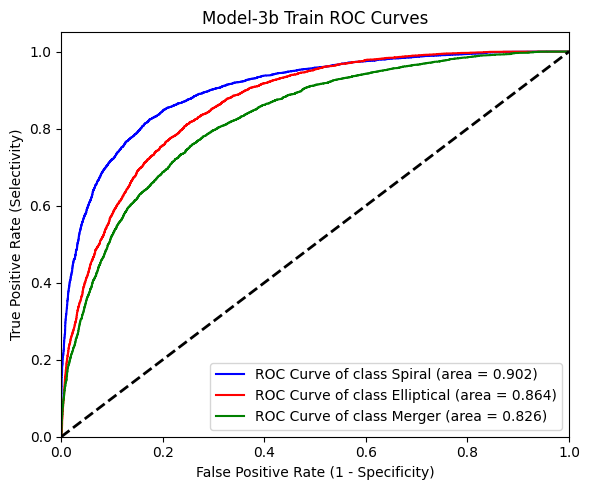

In [58]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model_3.predict(X_train_10)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_train, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Train:\n" + classification_metrics + '\n')

# Confusion Matrix
cd = make_cm(model_3, 
              np.argmax(Y_train, axis=1), 
              np.argmax(model_3.predict(X_train_10), axis=1)
              )
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'{model_3.name} Train Confusion Matrix')
plt.tight_layout()
plt.savefig(fname=f'{model_3.name}_train_CM', format='png')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_train[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title(f'{model_3.name} Train ROC Curves')
plt.savefig(fname=f'{model_3.name}_train_ROC', format='png')
plt.show()

210/210 [==============================] - 2s 11ms/step
Test:
              precision    recall  f1-score   support

      Spiral       0.88      0.54      0.67      2863
  Elliptical       0.37      0.94      0.53      1631
      Merger       0.73      0.27      0.39      2221

    accuracy                           0.55      6715
   macro avg       0.66      0.58      0.53      6715
weighted avg       0.71      0.55      0.55      6715


210/210 [==============================] - 2s 12ms/step


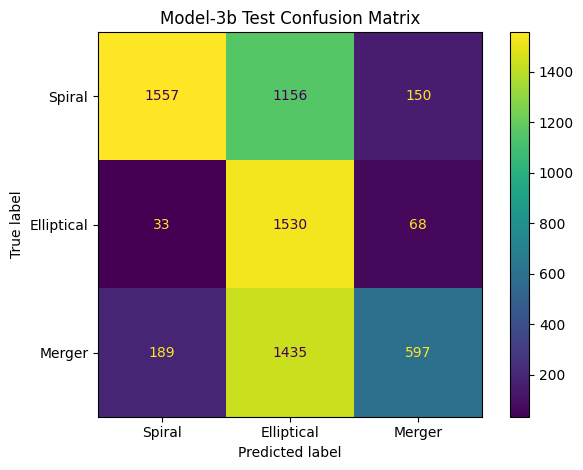

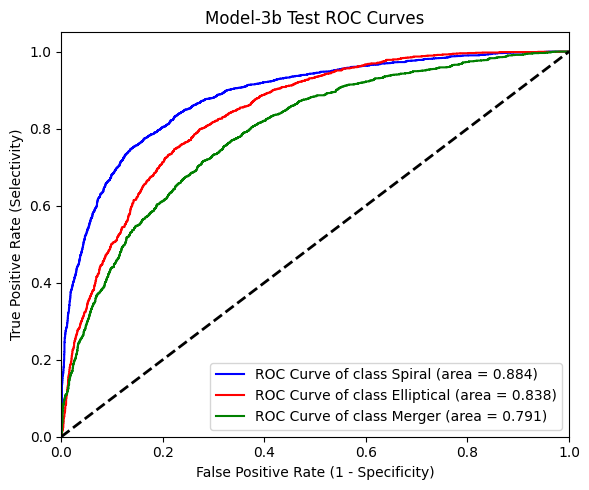

In [60]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model_3.predict(X_test_10)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_test, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Test:\n" + classification_metrics + '\n')

# Confusion Matrix
cd = make_cm(model_3, 
              np.argmax(Y_test, axis=1), 
              np.argmax(model_3.predict(X_test_10), axis=1)
              )
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'{model_3.name} Test Confusion Matrix')
plt.tight_layout()
plt.savefig(fname=f'{model_3.name}_test_CM', format='png')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title(f'{model_3.name} Test ROC Curves')
plt.savefig(fname=f'{model_3.name}_test_ROC', format='png')
plt.show()

105/105 [==============================] - 1s 11ms/step
Validation:
              precision    recall  f1-score   support

      Spiral       0.88      0.57      0.69      1432
  Elliptical       0.38      0.93      0.54       815
      Merger       0.73      0.30      0.43      1108

    accuracy                           0.57      3355
   macro avg       0.67      0.60      0.56      3355
weighted avg       0.71      0.57      0.57      3355


105/105 [==============================] - 1s 11ms/step


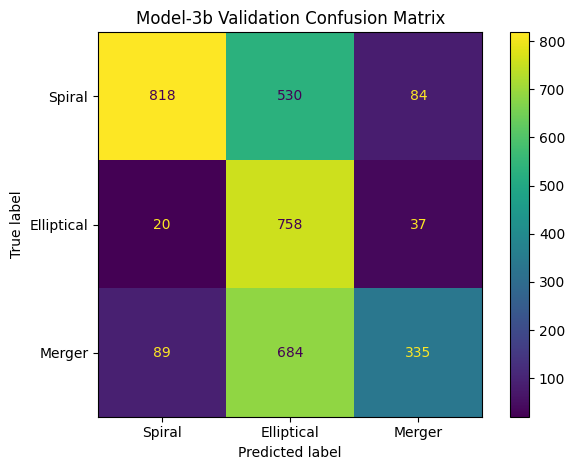

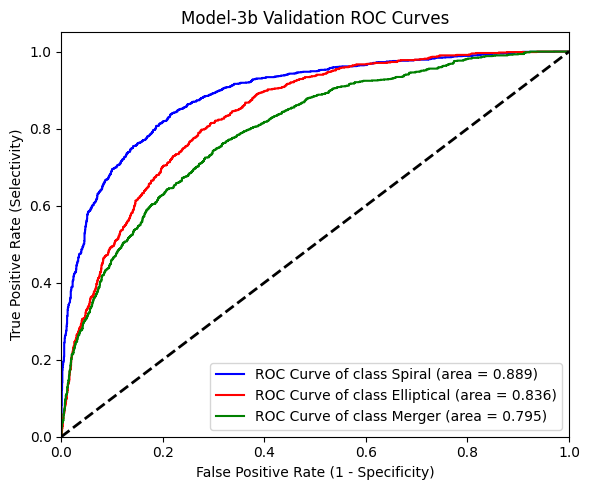

In [61]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model_3.predict(X_valid_10)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_valid, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Validation:\n" + classification_metrics + '\n')

# Confusion Matrix
cd = make_cm(model_3, 
              np.argmax(Y_valid, axis=1), 
              np.argmax(model_3.predict(X_valid_10), axis=1)
              )
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'{model_3.name} Validation Confusion Matrix')
plt.tight_layout()
plt.savefig(fname=f'{model_3.name}_validation_CM', format='png')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_valid[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title(f'{model_3.name} Validation ROC Curves')
plt.savefig(fname=f'{model_3.name}_validation_ROC', format='png')
plt.show()

In [1]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = model_3.predict(X_test_1)
        
# Classification report
classification_metrics = make_classification_report(
    np.argmax(Y_test, axis=1), 
    np.argmax(y_pred, axis=1)
    )
print("Year 1 Test:\n" + classification_metrics + '\n')

NameError: name 'model_3' is not defined

### ResNet18b Model

Use ResNet18 architecture

Loss: Categorical Cross-entropy

Optimizer: Adam

Uses Image Augmentation: False

Change: use ResNet18 model

In [17]:
class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0], data_format='channels_first',
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1], data_format='channels_first',
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(self.__channels, strides=2, kernel_size=(1, 1), data_format='channels_first',
                                   kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2, data_format='channels_first',
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), data_format='channels_first', strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D(data_format='channels_first')
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [18]:
# Initialize ResNet-18 model for 3 classes
resnet18_model = ResNet18(NUM_CLASSES)
resnet18_model.build(input_shape = (None, 3, 100, 100))

## Compile Model
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(lr=1e-5)
resnet18_model.compile(loss = loss, optimizer = optimizer, metrics = ['accuracy'])

resnet18_model.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-10-27 12:32:16.359908: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-27 12:32:16.361557: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  9472      
                                                                 
 batch_normalization (BatchN  multiple                 200       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 resnet_block (ResnetBlock)  multiple          

In [20]:
## Define Callback Functions

# Add tensorboard callback and log output folder
log_dir = "Y10_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10), 
      ModelCheckpoint(filepath='Y10_resnet18_best_weights', monitor='val_accuracy', 
                      mode='max', verbose=1, save_best_only=True),
      tensorboard_callback
      ]

In [21]:
## Train Model
batch_size = 128
NUM_EPOCH = 200

history_resnet18b = resnet18_model.fit(X_train_10, Y_train,
                                    batch_size = batch_size,
                                    epochs = NUM_EPOCH,
                                    validation_data = (X_valid_10, Y_valid),                
                                    shuffle = True,
                                    class_weight = class_weights,
                                    verbose = 1,
                                    callbacks = es
                                    )

Epoch 1/200


2022-10-27 12:35:19.541014: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-27 12:35:21.311258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


184/184 [==============================] - ETA: 0s - loss: 1.1235 - accuracy: 0.3594

2022-10-27 12:37:38.182163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.46796, saving model to Y10_resnet18_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 151s 795ms/step - loss: 1.1235 - accuracy: 0.3594 - val_loss: 1.0665 - val_accuracy: 0.4680
Epoch 2/200
184/184 [==============================] - ETA: 0s - loss: 1.0836 - accuracy: 0.4039
Epoch 2: val_accuracy did not improve from 0.46796
184/184 [==============================] - 136s 738ms/step - loss: 1.0836 - accuracy: 0.4039 - val_loss: 1.1149 - val_accuracy: 0.3490
Epoch 3/200
184/184 [==============================] - ETA: 0s - loss: 1.0664 - accuracy: 0.4314
Epoch 3: val_accuracy improved from 0.46796 to 0.48227, saving model to Y10_resnet18_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 144s 780ms/step - loss: 1.0664 - accuracy: 0.4314 - val_loss: 1.0397 - val_accuracy: 0.4823
Epoch 4/200
184/184 [==============================] - ETA: 0s - loss: 1.0267 - accuracy: 0.4892
Epoch 4: val_accuracy improved from 0.48227 to 0.51714, saving model to Y10_resnet18_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 145s 787ms/step - loss: 1.0267 - accuracy: 0.4892 - val_loss: 1.0183 - val_accuracy: 0.5171
Epoch 5/200
184/184 [==============================] - ETA: 0s - loss: 0.9849 - accuracy: 0.5149
Epoch 5: val_accuracy improved from 0.51714 to 0.55320, saving model to Y10_resnet18_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 153s 832ms/step - loss: 0.9849 - accuracy: 0.5149 - val_loss: 0.9370 - val_accuracy: 0.5532
Epoch 6/200
184/184 [==============================] - ETA: 0s - loss: 0.9484 - accuracy: 0.5354
Epoch 6: val_accuracy improved from 0.55320 to 0.55768, saving model to Y10_resnet18_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 153s 831ms/step - loss: 0.9484 - accuracy: 0.5354 - val_loss: 0.9039 - val_accuracy: 0.5577
Epoch 7/200
184/184 [==============================] - ETA: 0s - loss: 0.9158 - accuracy: 0.5615
Epoch 7: val_accuracy improved from 0.55768 to 0.59285, saving model to Y10_resnet18_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 154s 838ms/step - loss: 0.9158 - accuracy: 0.5615 - val_loss: 0.8631 - val_accuracy: 0.5928
Epoch 8/200
184/184 [==============================] - ETA: 0s - loss: 0.8705 - accuracy: 0.5902
Epoch 8: val_accuracy improved from 0.59285 to 0.59940, saving model to Y10_resnet18_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 149s 811ms/step - loss: 0.8705 - accuracy: 0.5902 - val_loss: 0.8808 - val_accuracy: 0.5994
Epoch 9/200
184/184 [==============================] - ETA: 0s - loss: 0.8461 - accuracy: 0.6051
Epoch 9: val_accuracy did not improve from 0.59940
184/184 [==============================] - 135s 733ms/step - loss: 0.8461 - accuracy: 0.6051 - val_loss: 0.8952 - val_accuracy: 0.5645
Epoch 10/200
184/184 [==============================] - ETA: 0s - loss: 0.8193 - accuracy: 0.6232
Epoch 10: val_accuracy improved from 0.59940 to 0.63428, saving model to Y10_resnet18_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 144s 784ms/step - loss: 0.8193 - accuracy: 0.6232 - val_loss: 0.7863 - val_accuracy: 0.6343
Epoch 11/200
184/184 [==============================] - ETA: 0s - loss: 0.7870 - accuracy: 0.6430
Epoch 11: val_accuracy did not improve from 0.63428
184/184 [==============================] - 136s 737ms/step - loss: 0.7870 - accuracy: 0.6430 - val_loss: 0.7889 - val_accuracy: 0.6322
Epoch 12/200
184/184 [==============================] - ETA: 0s - loss: 0.7629 - accuracy: 0.6559
Epoch 12: val_accuracy did not improve from 0.63428
184/184 [==============================] - 134s 728ms/step - loss: 0.7629 - accuracy: 0.6559 - val_loss: 0.8313 - val_accuracy: 0.6316
Epoch 13/200
184/184 [==============================] - ETA: 0s - loss: 0.7585 - accuracy: 0.6571
Epoch 13: val_accuracy improved from 0.63428 to 0.66379, saving model to Y10_resnet18_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 141s 768ms/step - loss: 0.7585 - accuracy: 0.6571 - val_loss: 0.7402 - val_accuracy: 0.6638
Epoch 14/200
184/184 [==============================] - ETA: 0s - loss: 0.7246 - accuracy: 0.6761
Epoch 14: val_accuracy improved from 0.66379 to 0.69031, saving model to Y10_resnet18_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 142s 774ms/step - loss: 0.7246 - accuracy: 0.6761 - val_loss: 0.7166 - val_accuracy: 0.6903
Epoch 15/200
184/184 [==============================] - ETA: 0s - loss: 0.7113 - accuracy: 0.6857
Epoch 15: val_accuracy did not improve from 0.69031
184/184 [==============================] - 134s 726ms/step - loss: 0.7113 - accuracy: 0.6857 - val_loss: 0.7347 - val_accuracy: 0.6775
Epoch 16/200
184/184 [==============================] - ETA: 0s - loss: 0.6955 - accuracy: 0.6954
Epoch 16: val_accuracy did not improve from 0.69031
184/184 [==============================] - 134s 729ms/step - loss: 0.6955 - accuracy: 0.6954 - val_loss: 0.7145 - val_accuracy: 0.6781
Epoch 17/200
184/184 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.6940
Epoch 17: val_accuracy did not improve from 0.69031
184/184 [==============================] - 133s 724ms/step - loss: 0.6935 - accuracy: 0.6940 - val_loss: 0.7092 - val_accuracy: 0.6838
Epoch 18/2

INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 141s 769ms/step - loss: 0.6756 - accuracy: 0.7063 - val_loss: 0.6864 - val_accuracy: 0.6948
Epoch 19/200
184/184 [==============================] - ETA: 0s - loss: 0.6599 - accuracy: 0.7138
Epoch 19: val_accuracy did not improve from 0.69478
184/184 [==============================] - 135s 733ms/step - loss: 0.6599 - accuracy: 0.7138 - val_loss: 0.6921 - val_accuracy: 0.6885
Epoch 20/200
184/184 [==============================] - ETA: 0s - loss: 0.6496 - accuracy: 0.7207
Epoch 20: val_accuracy improved from 0.69478 to 0.71088, saving model to Y10_resnet18_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 141s 768ms/step - loss: 0.6496 - accuracy: 0.7207 - val_loss: 0.6730 - val_accuracy: 0.7109
Epoch 21/200
184/184 [==============================] - ETA: 0s - loss: 0.6402 - accuracy: 0.7213
Epoch 21: val_accuracy did not improve from 0.71088
184/184 [==============================] - 134s 725ms/step - loss: 0.6402 - accuracy: 0.7213 - val_loss: 0.7568 - val_accuracy: 0.6581
Epoch 22/200
184/184 [==============================] - ETA: 0s - loss: 0.6209 - accuracy: 0.7343
Epoch 22: val_accuracy improved from 0.71088 to 0.71177, saving model to Y10_resnet18_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 141s 765ms/step - loss: 0.6209 - accuracy: 0.7343 - val_loss: 0.6563 - val_accuracy: 0.7118
Epoch 23/200
184/184 [==============================] - ETA: 0s - loss: 0.6200 - accuracy: 0.7320
Epoch 23: val_accuracy did not improve from 0.71177
184/184 [==============================] - 133s 725ms/step - loss: 0.6200 - accuracy: 0.7320 - val_loss: 0.6419 - val_accuracy: 0.7088
Epoch 24/200
184/184 [==============================] - ETA: 0s - loss: 0.6055 - accuracy: 0.7407
Epoch 24: val_accuracy did not improve from 0.71177
184/184 [==============================] - 134s 728ms/step - loss: 0.6055 - accuracy: 0.7407 - val_loss: 0.6693 - val_accuracy: 0.6930
Epoch 25/200
184/184 [==============================] - ETA: 0s - loss: 0.6035 - accuracy: 0.7410
Epoch 25: val_accuracy improved from 0.71177 to 0.73353, saving model to Y10_resnet18_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 142s 772ms/step - loss: 0.6035 - accuracy: 0.7410 - val_loss: 0.6191 - val_accuracy: 0.7335
Epoch 26/200
184/184 [==============================] - ETA: 0s - loss: 0.5705 - accuracy: 0.7587
Epoch 26: val_accuracy did not improve from 0.73353
184/184 [==============================] - 135s 733ms/step - loss: 0.5705 - accuracy: 0.7587 - val_loss: 0.6419 - val_accuracy: 0.7261
Epoch 27/200
184/184 [==============================] - ETA: 0s - loss: 0.5693 - accuracy: 0.7592
Epoch 27: val_accuracy did not improve from 0.73353
184/184 [==============================] - 134s 727ms/step - loss: 0.5693 - accuracy: 0.7592 - val_loss: 0.6118 - val_accuracy: 0.7332
Epoch 28/200
184/184 [==============================] - ETA: 0s - loss: 0.5697 - accuracy: 0.7582
Epoch 28: val_accuracy did not improve from 0.73353
184/184 [==============================] - 133s 725ms/step - loss: 0.5697 - accuracy: 0.7582 - val_loss: 0.6626 - val_accuracy: 0.7159
Epoch 29/2

INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 143s 777ms/step - loss: 0.5269 - accuracy: 0.7790 - val_loss: 0.5760 - val_accuracy: 0.7610
Epoch 33/200
184/184 [==============================] - ETA: 0s - loss: 0.5088 - accuracy: 0.7883
Epoch 33: val_accuracy did not improve from 0.76095
184/184 [==============================] - 135s 736ms/step - loss: 0.5088 - accuracy: 0.7883 - val_loss: 0.5880 - val_accuracy: 0.7452
Epoch 34/200
184/184 [==============================] - ETA: 0s - loss: 0.5135 - accuracy: 0.7855
Epoch 34: val_accuracy did not improve from 0.76095
184/184 [==============================] - 135s 734ms/step - loss: 0.5135 - accuracy: 0.7855 - val_loss: 0.6117 - val_accuracy: 0.7461
Epoch 35/200
184/184 [==============================] - ETA: 0s - loss: 0.4939 - accuracy: 0.7946
Epoch 35: val_accuracy did not improve from 0.76095
184/184 [==============================] - 136s 741ms/step - loss: 0.4939 - accuracy: 0.7946 - val_loss: 0.7218 - val_accuracy: 0.6909
Epoch 36/2

INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 147s 799ms/step - loss: 0.4605 - accuracy: 0.8115 - val_loss: 0.5598 - val_accuracy: 0.7660
Epoch 39/200
184/184 [==============================] - ETA: 0s - loss: 0.4594 - accuracy: 0.8099
Epoch 39: val_accuracy did not improve from 0.76602
184/184 [==============================] - 142s 770ms/step - loss: 0.4594 - accuracy: 0.8099 - val_loss: 0.7260 - val_accuracy: 0.6930
Epoch 40/200
184/184 [==============================] - ETA: 0s - loss: 0.4583 - accuracy: 0.8135
Epoch 40: val_accuracy did not improve from 0.76602
184/184 [==============================] - 139s 755ms/step - loss: 0.4583 - accuracy: 0.8135 - val_loss: 0.5601 - val_accuracy: 0.7618
Epoch 41/200
184/184 [==============================] - ETA: 0s - loss: 0.4300 - accuracy: 0.8266
Epoch 41: val_accuracy did not improve from 0.76602
184/184 [==============================] - 140s 760ms/step - loss: 0.4300 - accuracy: 0.8266 - val_loss: 0.6000 - val_accuracy: 0.7458
Epoch 42/2

INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 144s 785ms/step - loss: 0.4218 - accuracy: 0.8294 - val_loss: 0.5540 - val_accuracy: 0.7744
Epoch 44/200
184/184 [==============================] - ETA: 0s - loss: 0.4233 - accuracy: 0.8268
Epoch 44: val_accuracy did not improve from 0.77437
184/184 [==============================] - 136s 741ms/step - loss: 0.4233 - accuracy: 0.8268 - val_loss: 0.5484 - val_accuracy: 0.7672
Epoch 45/200
184/184 [==============================] - ETA: 0s - loss: 0.4005 - accuracy: 0.8396
Epoch 45: val_accuracy improved from 0.77437 to 0.77526, saving model to Y10_resnet18_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 145s 786ms/step - loss: 0.4005 - accuracy: 0.8396 - val_loss: 0.5417 - val_accuracy: 0.7753
Epoch 46/200
184/184 [==============================] - ETA: 0s - loss: 0.4061 - accuracy: 0.8361
Epoch 46: val_accuracy did not improve from 0.77526
184/184 [==============================] - 137s 747ms/step - loss: 0.4061 - accuracy: 0.8361 - val_loss: 0.5885 - val_accuracy: 0.7541
Epoch 47/200
184/184 [==============================] - ETA: 0s - loss: 0.3888 - accuracy: 0.8441
Epoch 47: val_accuracy did not improve from 0.77526
184/184 [==============================] - 140s 758ms/step - loss: 0.3888 - accuracy: 0.8441 - val_loss: 0.5672 - val_accuracy: 0.7735
Epoch 48/200
184/184 [==============================] - ETA: 0s - loss: 0.3929 - accuracy: 0.8419
Epoch 48: val_accuracy did not improve from 0.77526
184/184 [==============================] - 139s 757ms/step - loss: 0.3929 - accuracy: 0.8419 - val_loss: 0.6141 - val_accuracy: 0.7478
Epoch 49/2

INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 146s 796ms/step - loss: 0.3729 - accuracy: 0.8518 - val_loss: 0.5364 - val_accuracy: 0.7839
Epoch 50/200
184/184 [==============================] - ETA: 0s - loss: 0.3742 - accuracy: 0.8492
Epoch 50: val_accuracy improved from 0.78390 to 0.78957, saving model to Y10_resnet18_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 147s 800ms/step - loss: 0.3742 - accuracy: 0.8492 - val_loss: 0.5291 - val_accuracy: 0.7896
Epoch 51/200
184/184 [==============================] - ETA: 0s - loss: 0.3614 - accuracy: 0.8587
Epoch 51: val_accuracy did not improve from 0.78957
184/184 [==============================] - 139s 756ms/step - loss: 0.3614 - accuracy: 0.8587 - val_loss: 0.5915 - val_accuracy: 0.7613
Epoch 52/200
184/184 [==============================] - ETA: 0s - loss: 0.3551 - accuracy: 0.8597
Epoch 52: val_accuracy did not improve from 0.78957
184/184 [==============================] - 139s 757ms/step - loss: 0.3551 - accuracy: 0.8597 - val_loss: 0.6082 - val_accuracy: 0.7627
Epoch 53/200
184/184 [==============================] - ETA: 0s - loss: 0.3449 - accuracy: 0.8647
Epoch 53: val_accuracy improved from 0.78957 to 0.79225, saving model to Y10_resnet18_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 148s 806ms/step - loss: 0.3449 - accuracy: 0.8647 - val_loss: 0.5244 - val_accuracy: 0.7923
Epoch 54/200
184/184 [==============================] - ETA: 0s - loss: 0.3409 - accuracy: 0.8650
Epoch 54: val_accuracy did not improve from 0.79225
184/184 [==============================] - 138s 752ms/step - loss: 0.3409 - accuracy: 0.8650 - val_loss: 0.5799 - val_accuracy: 0.7651
Epoch 55/200
184/184 [==============================] - ETA: 0s - loss: 0.3133 - accuracy: 0.8784
Epoch 55: val_accuracy improved from 0.79225 to 0.80328, saving model to Y10_resnet18_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 146s 796ms/step - loss: 0.3133 - accuracy: 0.8784 - val_loss: 0.5116 - val_accuracy: 0.8033
Epoch 56/200
184/184 [==============================] - ETA: 0s - loss: 0.3238 - accuracy: 0.8738
Epoch 56: val_accuracy improved from 0.80328 to 0.81371, saving model to Y10_resnet18_best_weights


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 148s 804ms/step - loss: 0.3238 - accuracy: 0.8738 - val_loss: 0.4852 - val_accuracy: 0.8137
Epoch 57/200
184/184 [==============================] - ETA: 0s - loss: 0.3138 - accuracy: 0.8774
Epoch 57: val_accuracy did not improve from 0.81371
184/184 [==============================] - 139s 755ms/step - loss: 0.3138 - accuracy: 0.8774 - val_loss: 0.5287 - val_accuracy: 0.7946
Epoch 58/200
184/184 [==============================] - ETA: 0s - loss: 0.3112 - accuracy: 0.8779
Epoch 58: val_accuracy did not improve from 0.81371
184/184 [==============================] - 139s 757ms/step - loss: 0.3112 - accuracy: 0.8779 - val_loss: 0.5733 - val_accuracy: 0.7845
Epoch 59/200
184/184 [==============================] - ETA: 0s - loss: 0.3117 - accuracy: 0.8790
Epoch 59: val_accuracy did not improve from 0.81371
184/184 [==============================] - 141s 767ms/step - loss: 0.3117 - accuracy: 0.8790 - val_loss: 0.6151 - val_accuracy: 0.7651
Epoch 60/2

INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 144s 781ms/step - loss: 0.2814 - accuracy: 0.8899 - val_loss: 0.4861 - val_accuracy: 0.8188
Epoch 62/200
184/184 [==============================] - ETA: 0s - loss: 0.2787 - accuracy: 0.8935
Epoch 62: val_accuracy did not improve from 0.81878
184/184 [==============================] - 136s 738ms/step - loss: 0.2787 - accuracy: 0.8935 - val_loss: 0.5049 - val_accuracy: 0.8113
Epoch 63/200
184/184 [==============================] - ETA: 0s - loss: 0.2757 - accuracy: 0.8939
Epoch 63: val_accuracy did not improve from 0.81878
184/184 [==============================] - 136s 741ms/step - loss: 0.2757 - accuracy: 0.8939 - val_loss: 0.5333 - val_accuracy: 0.7976
Epoch 64/200
184/184 [==============================] - ETA: 0s - loss: 0.2775 - accuracy: 0.8915
Epoch 64: val_accuracy did not improve from 0.81878
184/184 [==============================] - 136s 741ms/step - loss: 0.2775 - accuracy: 0.8915 - val_loss: 0.4900 - val_accuracy: 0.8182
Epoch 65/2

INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


INFO:tensorflow:Assets written to: Y10_resnet18_best_weights/assets


184/184 [==============================] - 144s 781ms/step - loss: 0.2580 - accuracy: 0.9011 - val_loss: 0.4787 - val_accuracy: 0.8265
Epoch 67/200
184/184 [==============================] - ETA: 0s - loss: 0.2453 - accuracy: 0.9079
Epoch 67: val_accuracy did not improve from 0.82653
184/184 [==============================] - 135s 736ms/step - loss: 0.2453 - accuracy: 0.9079 - val_loss: 0.4852 - val_accuracy: 0.8218
Epoch 68/200
184/184 [==============================] - ETA: 0s - loss: 0.2542 - accuracy: 0.9028
Epoch 68: val_accuracy did not improve from 0.82653
184/184 [==============================] - 137s 744ms/step - loss: 0.2542 - accuracy: 0.9028 - val_loss: 0.5096 - val_accuracy: 0.8152
Epoch 69/200
184/184 [==============================] - ETA: 0s - loss: 0.2551 - accuracy: 0.8999
Epoch 69: val_accuracy did not improve from 0.82653
184/184 [==============================] - 136s 737ms/step - loss: 0.2551 - accuracy: 0.8999 - val_loss: 0.5754 - val_accuracy: 0.7964
Epoch 70/2

In [22]:
%tensorboard --logdir Y10_logs

INFO:tensorflow:Assets written to: ResNet18-Y10/assets


INFO:tensorflow:Assets written to: ResNet18-Y10/assets


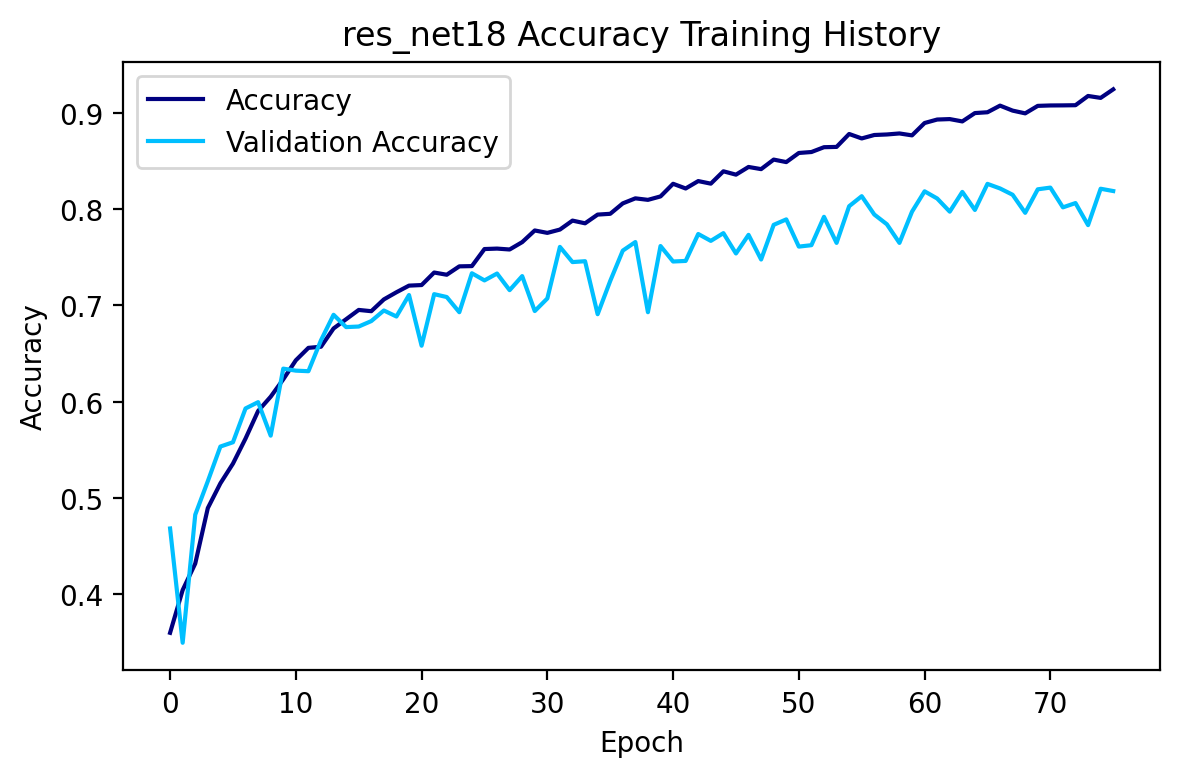

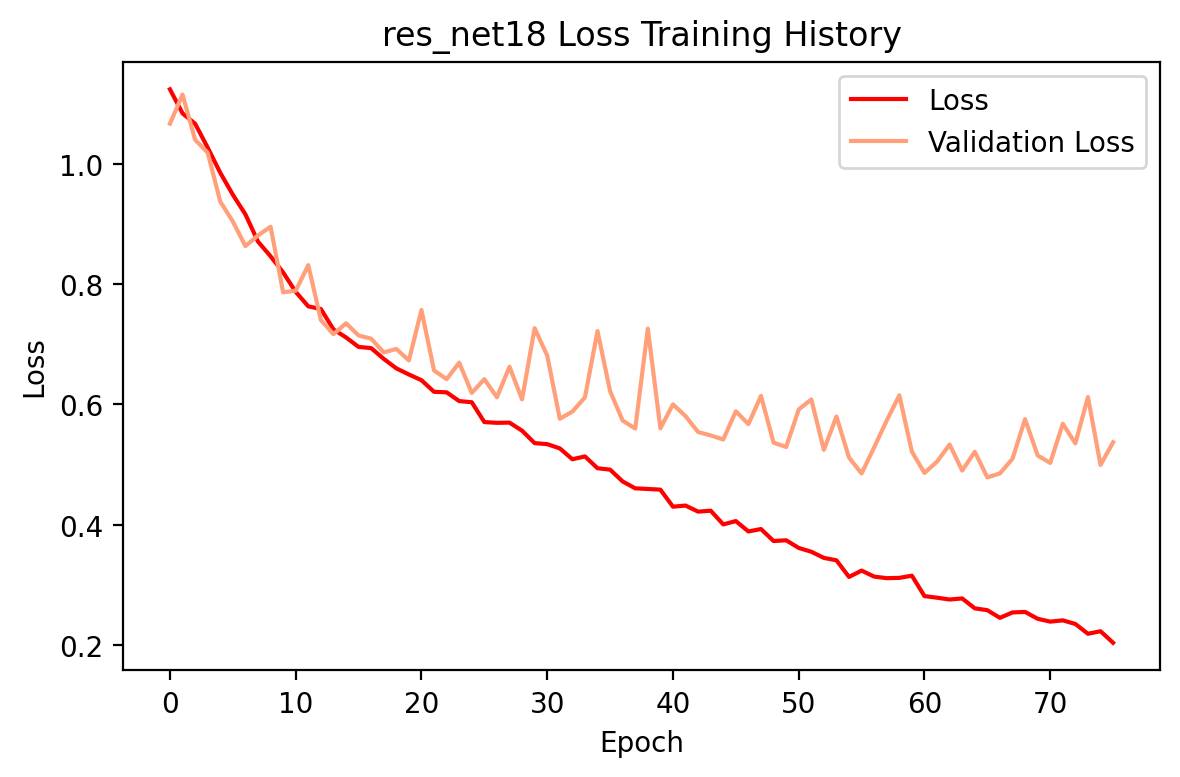

In [23]:
# Save model data
resnet18_model.save(filepath = 'ResNet18-Y10',
           include_optimizer = True, 
           overwrite = True)
    
# Saving history as .npy file for future use
np.save('history_resnet18b.npy', history_resnet18b.history)

# Plot training history
plot_training(resnet18_model, history_resnet18b)

2022-10-27 16:59:13.928682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


734/734 [==============================] - 27s 36ms/step
Train:
              precision    recall  f1-score   support

      Spiral       0.96      0.92      0.94     10017
  Elliptical       0.82      0.98      0.89      5705
      Merger       0.97      0.89      0.93      7765

    accuracy                           0.93     23487
   macro avg       0.92      0.93      0.92     23487
weighted avg       0.93      0.93      0.93     23487


734/734 [==============================] - 35s 45ms/step


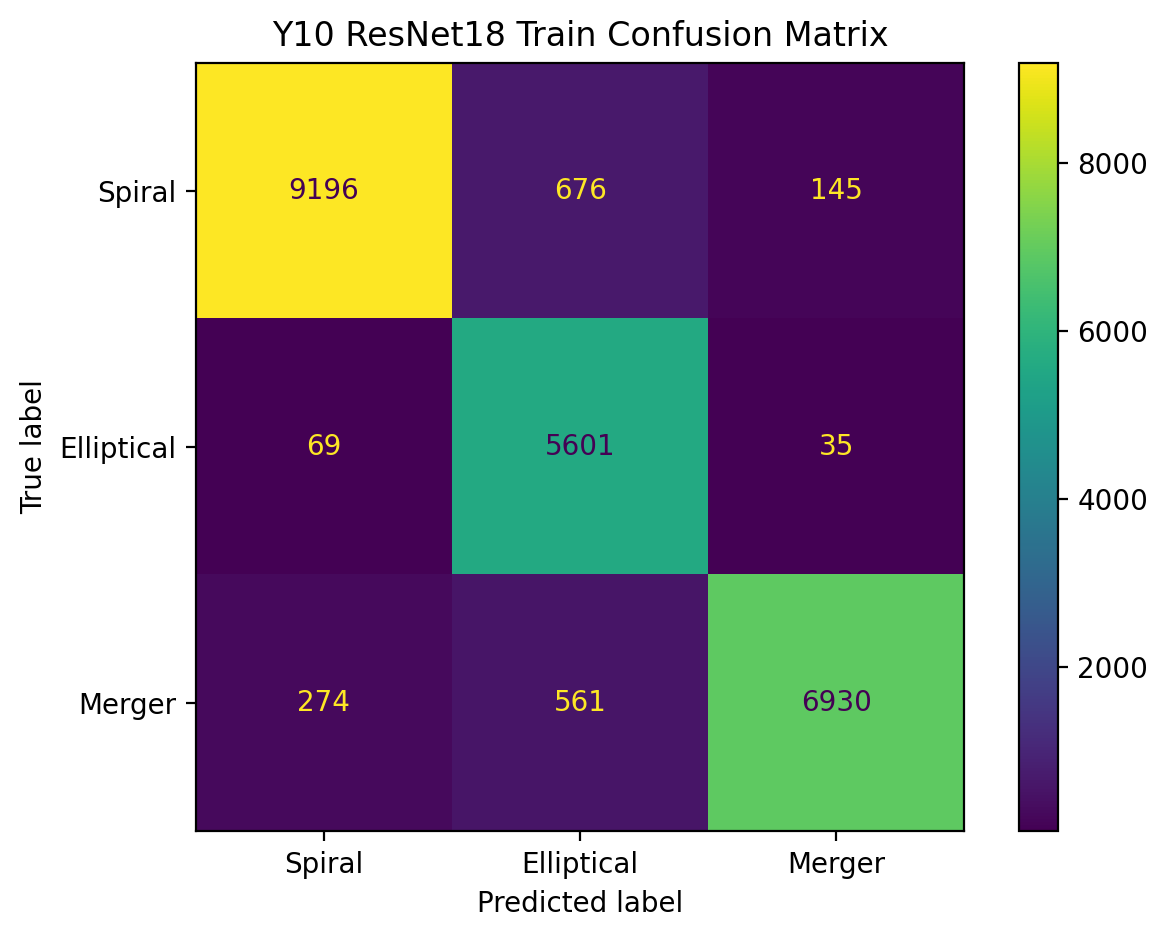

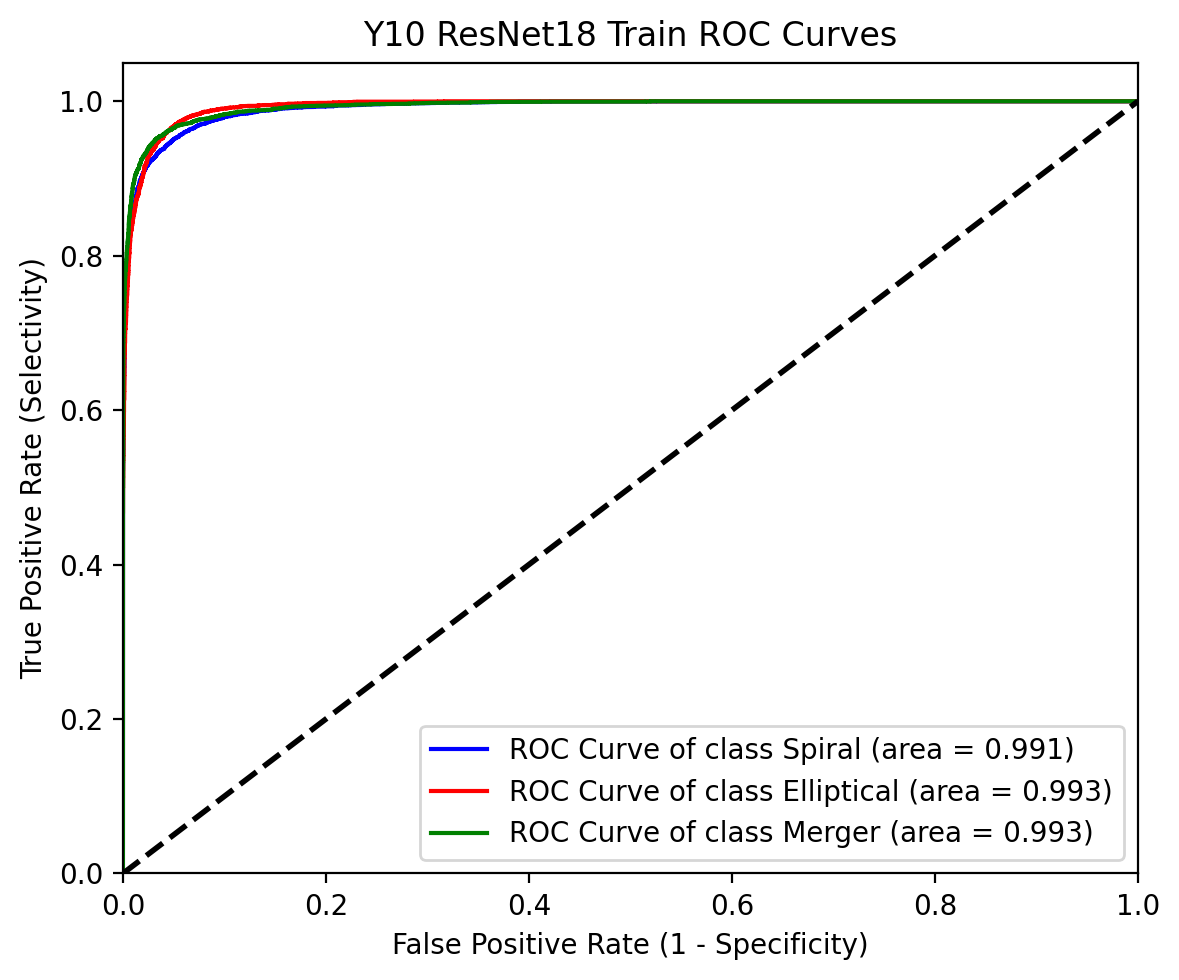

In [25]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = resnet18_model.predict(X_train_10)
        
# Classification report
classification_metrics = classification_report(np.argmax(Y_train, axis=1), 
                                               np.argmax(y_pred, axis=1), 
                                               target_names=class_names)
print("Train:\n" + classification_metrics + '\n')

# Confusion Matrix
cm = confusion_matrix(np.argmax(Y_train, axis=1), 
                      np.argmax(resnet18_model.predict(X_train_10), axis=1),
                      labels=[0, 1, 2])
cm = cm.astype('float')
cd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Y10 ResNet18 Train Confusion Matrix')
plt.tight_layout()
plt.savefig(fname='Y10_ResNet18_train_CM', format='png')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_train[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title('Y10 ResNet18 Train ROC Curves')
plt.savefig(fname='Y10_ResNet18_train_ROC', format='png')
plt.show()

210/210 [==============================] - 9s 42ms/step
Train:
              precision    recall  f1-score   support

      Spiral       0.88      0.84      0.86      2863
  Elliptical       0.67      0.87      0.76      1631
      Merger       0.86      0.72      0.78      2221

    accuracy                           0.81      6715
   macro avg       0.80      0.81      0.80      6715
weighted avg       0.82      0.81      0.81      6715


210/210 [==============================] - 7s 33ms/step


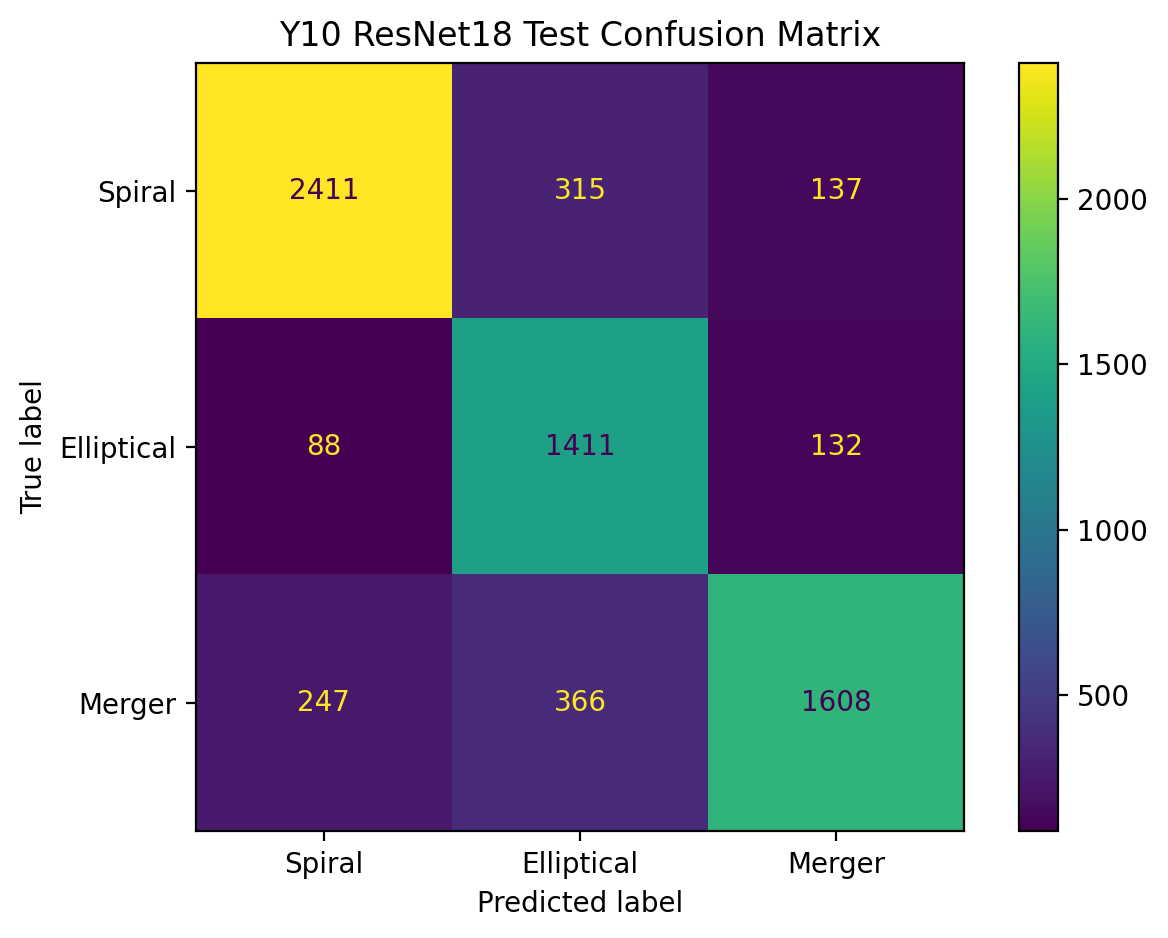

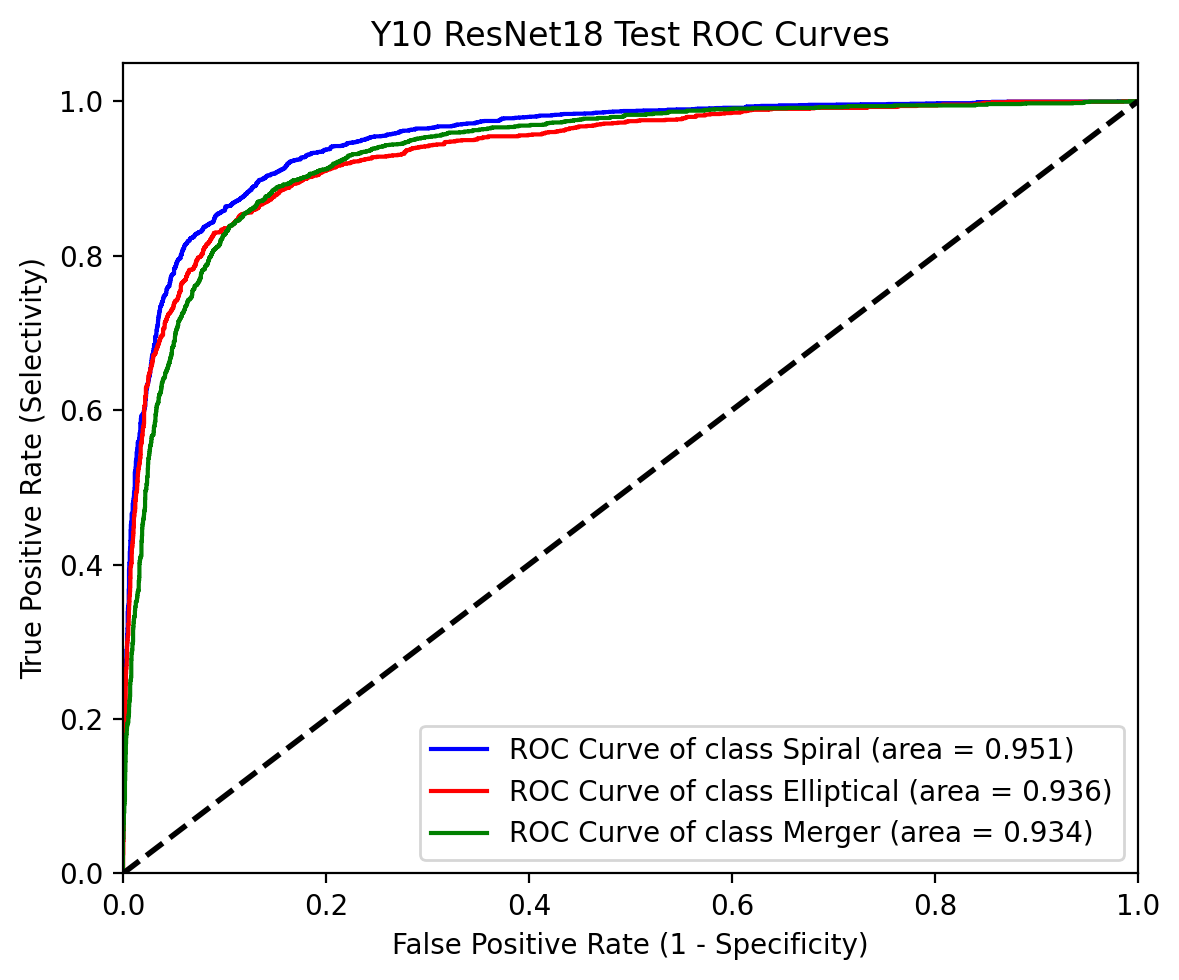

In [26]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = resnet18_model.predict(X_test_10)
        
# Classification report
classification_metrics = classification_report(np.argmax(Y_test, axis=1), 
                                               np.argmax(y_pred, axis=1), 
                                               target_names=class_names)
print("Train:\n" + classification_metrics + '\n')

# Confusion Matrix
cm = confusion_matrix(np.argmax(Y_test, axis=1), 
                      np.argmax(resnet18_model.predict(X_test_10), axis=1),
                      labels=[0, 1, 2])
cm = cm.astype('float')
cd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Y10 ResNet18 Test Confusion Matrix')
plt.tight_layout()
plt.savefig(fname='Y10_ResNet18_test_CM', format='png')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title('Y10 ResNet18 Test ROC Curves')
plt.savefig(fname='Y10_ResNet18_test_ROC', format='png')
plt.show()

105/105 [==============================] - 4s 38ms/step
Train:
              precision    recall  f1-score   support

      Spiral       0.89      0.85      0.87      1432
  Elliptical       0.68      0.87      0.76       815
      Merger       0.86      0.75      0.80      1108

    accuracy                           0.82      3355
   macro avg       0.81      0.82      0.81      3355
weighted avg       0.83      0.82      0.82      3355


105/105 [==============================] - 5s 46ms/step


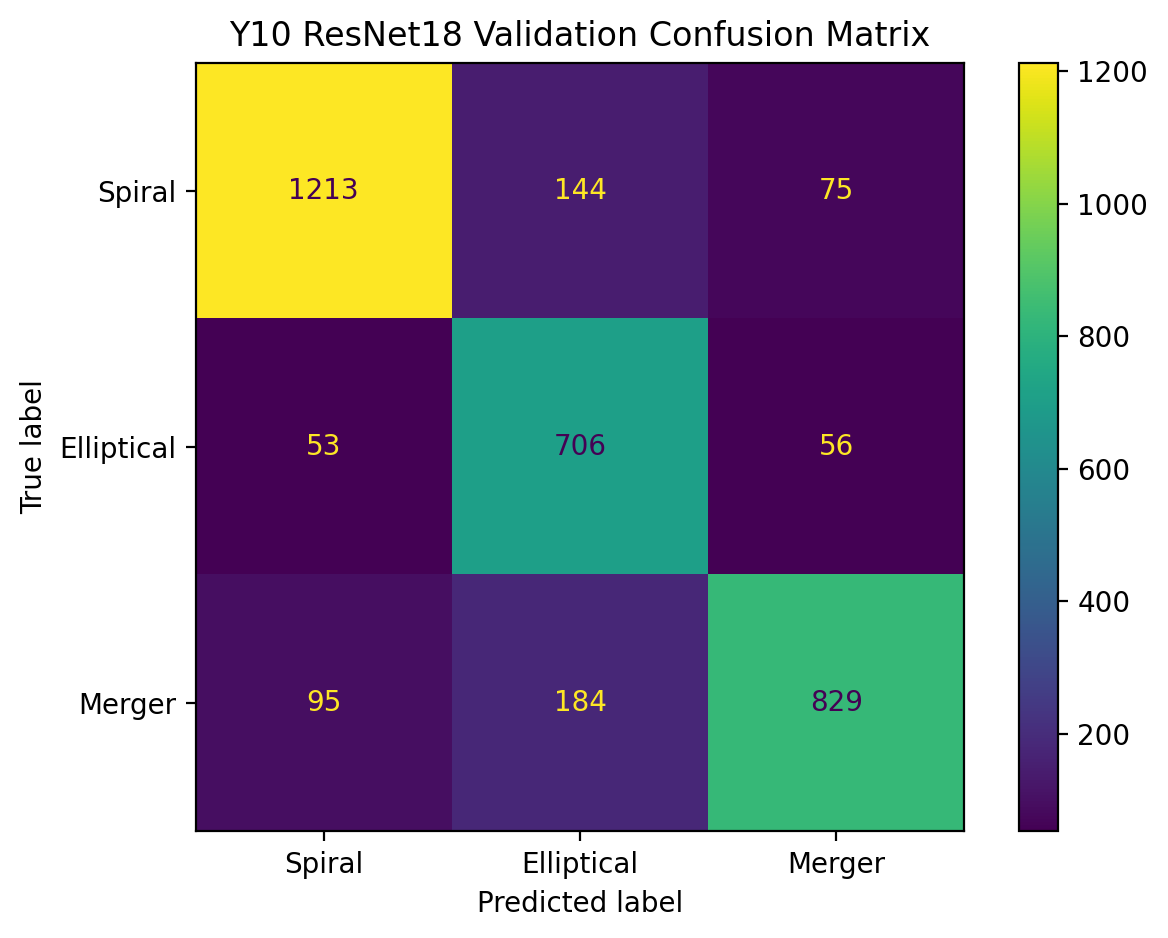

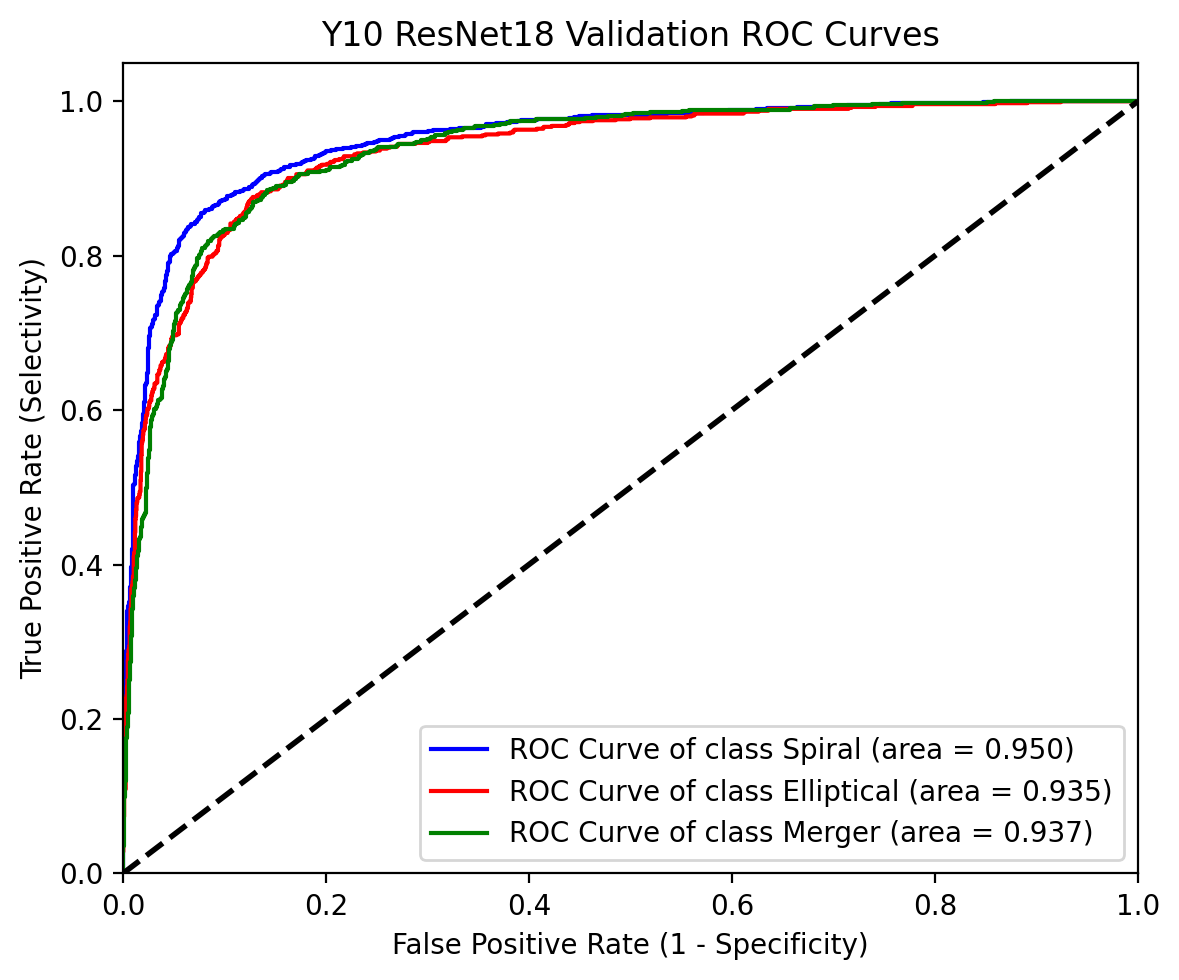

In [29]:
# Make Classification report, Confusion Matrix, and compute ROC & AUC for each class in each dataset
y_pred = resnet18_model.predict(X_valid_10)
        
# Classification report
classification_metrics = classification_report(np.argmax(Y_valid, axis=1), 
                                               np.argmax(y_pred, axis=1), 
                                               target_names=class_names)
print("Train:\n" + classification_metrics + '\n')

# Confusion Matrix
cm = confusion_matrix(np.argmax(Y_valid, axis=1), 
                      np.argmax(resnet18_model.predict(X_valid_10), axis=1),
                      labels=[0, 1, 2])
cm = cm.astype('float')
cd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cd.plot(values_format='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Y10 ResNet18 Validation Confusion Matrix')
plt.tight_layout()
plt.savefig(fname='Y10_ResNet18_valid_CM', format='png')
plt.show()

## ROC curves & AUC for a categorical classifier
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], thresholds = roc_curve(Y_valid[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize = (6, 5), tight_layout=True)
colors = ['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan']
for i, color, lbl in zip(range(NUM_CLASSES), colors, class_names):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
    label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Selectivity)')
plt.legend(loc="lower right")
plt.title('Y10 ResNet18 Validation ROC Curves')
plt.savefig(fname='Y10_ResNet18_validation_ROC', format='png')
plt.show()

In [28]:
# Make Classification report
y_pred = resnet18_model.predict(X_test_1)
        
# Classification report
classification_metrics = classification_report(np.argmax(Y_test, axis=1), 
                                               np.argmax(y_pred, axis=1), 
                                               target_names=class_names)
print("Year 1 Test:\n" + classification_metrics + '\n')

210/210 [==============================] - 9s 41ms/step
Year 1 Test:
              precision    recall  f1-score   support

      Spiral       0.80      0.58      0.67      2863
  Elliptical       0.52      0.26      0.34      1631
      Merger       0.48      0.82      0.61      2221

    accuracy                           0.58      6715
   macro avg       0.60      0.55      0.54      6715
weighted avg       0.63      0.58      0.57      6715


